In [2]:
#%pip install seaborn pandas kaggle opensmile pydub tqdm pyarrow

In [3]:
#%pip install joblib

In [1]:
#%pip install comet_ml

In [1]:
import comet_ml
from comet_ml import Experiment
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import opensmile
import glob
from IPython.display import Audio
from pydub import AudioSegment
import tqdm
from joblib import dump, load
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from optuna import create_study, logging
from optuna.integration import XGBoostPruningCallback
import re
%matplotlib inline

C:\Users\Анна\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Анна\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#функции для формирования классов для аудио
emotions = {
    0: 'pleased',
    1: 'happy',
    2: 'excited',
    3: 'anger',
    4: 'anger',
    5: 'anger',
    6: 'sad',
    7: 'bored',
    8: 'sleepy',
    9: 'contentment',
    10: 'contentment',
    11: 'contentment'
}

def normilize(x):
    return ((x-5)/4)

def get_class(arousal, valence):
    angle = np.arctan2(normilize(arousal), normilize(valence))
    angle = (angle + 2 * np.pi) % (2 * np.pi)
    num_emotions = 12
    emotion_class = int(np.floor(angle / (2 * np.pi / num_emotions)))
    return emotions[emotion_class]

In [3]:
df = pd.read_csv('../Downloads/features.csv')
df_annotations = pd.read_csv('../Downloads/annotations.csv')

In [4]:
classes = [get_class(df_annotations['arousal'].loc[i], df_annotations['valence'].loc[i]) for i in df_annotations.index]

In [5]:
df['emotion_class'] = classes

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
model_pca = PCA()
model_pca.fit(X)

PCA()

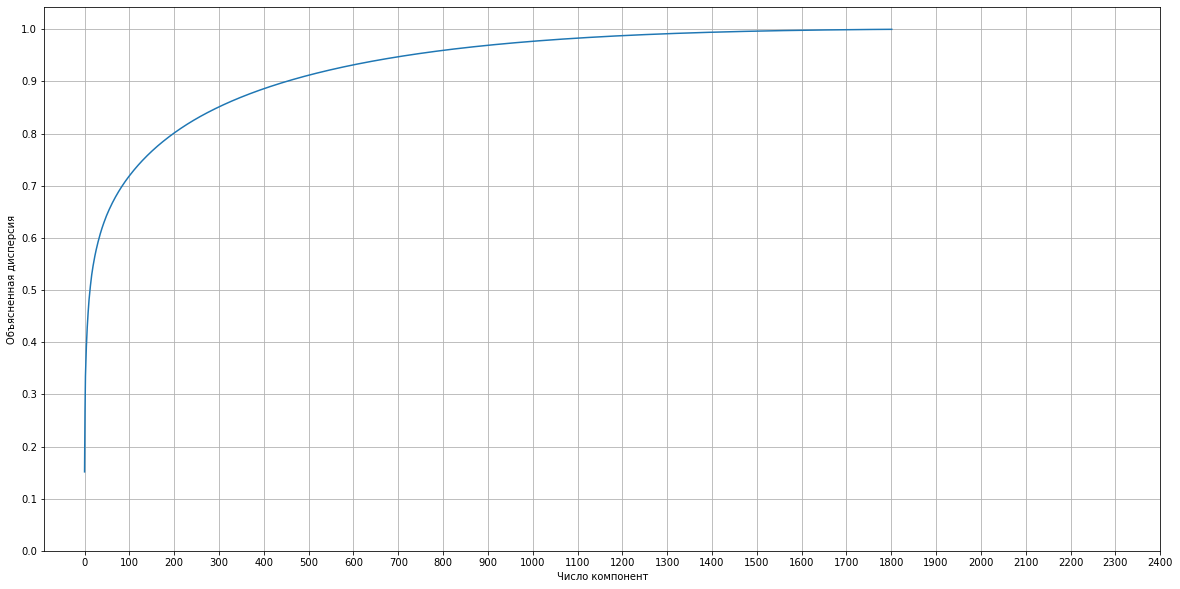

In [11]:
plt.figure(figsize=(20,10))
plt.plot(model_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Число компонент')
plt.ylabel('Объясненная дисперсия')
plt.xticks(np.arange(0, 2500, 100))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.show();

In [16]:
print(model_pca.explained_variance_ratio_.cumsum()[1000]*100)

97.70710963209095


In [69]:
model_pca_1000 = PCA(n_components=1000)
X_1000_feat = model_pca_1000.fit_transform(X)

In [110]:
#первоначальный неправильный подход с gridsearch
X_train, X_test, y_train, y_test = train_test_split(X_1250_feat, y, stratify=y, test_size = 0.3, random_state = 10)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

params_grid = { 
    'max_depth': [1, 2, 3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [10, 50, 100, 150],
    'random_state': [10]
}

xgb_clf = xgb.XGBClassifier()
                                   
kf = StratifiedKFold(n_splits=5,random_state=10,shuffle=True)

#def my_recall(y_true, y_pred):
#    return recall_score(y_true, y_pred, average='macro')
#recall = make_scorer(my_recall, greater_is_better=True)

model = GridSearchCV(
    estimator = xgb_clf,
    param_grid = params_grid,
    scoring = 'f1_macro',
    n_jobs = 4,
    cv = kf,
    verbose = 2,
    error_score='raise',
    refit=True
)

model.fit(X_train, y_train, sample_weight=sample_weights)

estimator = model.best_estimator_

experiment = Experiment(project_name="audio_classification",
                            workspace="annkash",
                            api_key="lN5LpQvmYz3MYRVdRxpAN6Jn9")
experiment.set_name('XGBoost, grid search with f1-macro best 1250 comp')
experiment.add_tags(['gridsearch'])
experiment.log_parameters(params_grid)
y_true = y_test
y_pred = estimator.predict(X_test)
cm = confusion_matrix(y_true, y_pred, labels=estimator.classes_)
experiment.log_confusion_matrix(y_true, y_pred)
experiment.log_metrics({'precision_macro': precision_score(y_true, y_pred, average='macro'),
                       'accuracy': accuracy_score(y_true, y_pred),
                       'recall_macro': recall_score(y_true, y_pred, average='macro'),
                       'f1_macro': f1_score(y_true, y_pred, average='macro')})
experiment.end()

dump(estimator, '../Downloads/gscv_model_1250_pca_f1_macro.joblib')

target_names = label_encoder.classes_

#оценки на тренировочной выборке
y_true = y_train
y_pred = model.predict(X_train)
print(classification_report(y_true, y_pred, target_names=target_names))

#оценки на тестовой выборке
y_true = y_test
y_pred = model.predict(X_test)
print(classification_report(y_true, y_pred, target_names=target_names))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END learning_rate=0.01, max_depth=1, n_estimators=10, random_state=10; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=10, random_state=10; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=10, random_state=10; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=10, random_state=10; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=10, random_state=10; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=50, random_state=10; total time=   6.3s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=50, random_state=10; total time=   6.6s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=50, random_state=10; total time=   6.1s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=50, random_state=10; total time=   6.1s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=50, random_state=10; total t

[CV] END learning_rate=0.01, max_depth=5, n_estimators=50, random_state=10; total time=  42.8s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=50, random_state=10; total time=  43.5s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=50, random_state=10; total time=  42.8s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=50, random_state=10; total time=  45.4s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, random_state=10; total time= 1.6min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, random_state=10; total time= 1.5min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, random_state=10; total time= 1.5min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, random_state=10; total time= 1.5min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, random_state=10; total time= 1.5min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=150, random_state=10; total time= 2.2min
[CV] END learning_rate=0.01, max_depth=5, n_

[CV] END learning_rate=0.1, max_depth=4, n_estimators=100, random_state=10; total time=  55.2s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=100, random_state=10; total time=  57.7s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=150, random_state=10; total time= 1.4min
[CV] END learning_rate=0.1, max_depth=4, n_estimators=150, random_state=10; total time= 1.4min
[CV] END learning_rate=0.1, max_depth=4, n_estimators=150, random_state=10; total time= 1.4min
[CV] END learning_rate=0.1, max_depth=4, n_estimators=150, random_state=10; total time= 1.4min
[CV] END learning_rate=0.1, max_depth=4, n_estimators=150, random_state=10; total time= 1.3min
[CV] END learning_rate=0.1, max_depth=5, n_estimators=10, random_state=10; total time=   9.0s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=10, random_state=10; total time=   9.9s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=10, random_state=10; total time=   8.9s
[CV] END learning_rate=0.1, max_depth=5, n_estimators

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Анна\\Downloads' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/annkash/audio-classification/91a698a30f634738b3345ad0aecc5b55

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/annkash/audio-classification/91a698a30f634738b3345ad0aecc5b

COMET INFO:   Metrics:
COMET INFO:     mean_fit_time       : 12.81409740447998
COMET INFO:     mean_score_time     : 0.009001541137695312
COMET INFO:     mean_test_score     : 0.25549022357130696
COMET INFO:     param_learning_rate : 0.01
COMET INFO:     param_max_depth     : 1
COMET INFO:     param_n_estimators  : 100
COMET INFO:     param_random_state  : 10
COMET INFO:     rank_test_score     : 37
COMET INFO:     split0_test_score   : 0.22724743411544057
COMET INFO:     split1_test_score   : 0.23528193173077153
COMET INFO:     split2_test_score   : 0.29640556227091847
COMET INFO:     split3_test_score   : 0.243927014015075
COMET INFO:     split4_test_score   : 0.27458917572432956
COMET INFO:     std_fit_time        : 0.5349798965704422
COMET INFO:     std_score_time      : 0.001270866501390366
COMET INFO:     std_test_score      : 0.02599451074688407
COMET INFO:   Others:
COMET INFO:     Name : XGBoost, grid search with f1-weighted score iteration #3
COMET INFO:   Parameters:
COMET I

COMET INFO:     rank_test_score     : 35
COMET INFO:     split0_test_score   : 0.24057753652028693
COMET INFO:     split1_test_score   : 0.28675020082130703
COMET INFO:     split2_test_score   : 0.2859916499385207
COMET INFO:     split3_test_score   : 0.2627911475672645
COMET INFO:     split4_test_score   : 0.2990093529925828
COMET INFO:     std_fit_time        : 0.021744829863104363
COMET INFO:     std_score_time      : 0.0031295081032484883
COMET INFO:     std_test_score      : 0.02082926697679075
COMET INFO:   Others:
COMET INFO:     Name : XGBoost, grid search with f1-weighted score iteration #5
COMET INFO:   Parameters:
COMET INFO:     learning_rate : 0.01
COMET INFO:     max_depth     : 2
COMET INFO:     n_estimators  : 10
COMET INFO:     random_state  : 10
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET I

COMET INFO:     split4_test_score   : 0.3587980774162964
COMET INFO:     std_fit_time        : 0.09188013951605363
COMET INFO:     std_score_time      : 0.00044511862716888165
COMET INFO:     std_test_score      : 0.027146595345500873
COMET INFO:   Others:
COMET INFO:     Name : XGBoost, grid search with f1-weighted score iteration #7
COMET INFO:   Parameters:
COMET INFO:     learning_rate : 0.01
COMET INFO:     max_depth     : 2
COMET INFO:     n_estimators  : 100
COMET INFO:     random_state  : 10
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_m

COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 5 file(s), remaining 172.16 KB/295.21 KB
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Анна\\Downloads' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/annkash/audio-classification/0826cedb0d4246

COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/annkash/audio-classification/1f04925eda934ed4814676d9af07bd7f
COMET INFO:   Metrics:
COMET INFO:     mean_fit_time       : 54.8935450553894
COMET INFO:     mean_score_time     : 0.009703969955444336
COMET INFO:     mean_test_score     : 0.4201787575465887
COMET INFO:     param_learning_rate : 0.01
COMET INFO:     param_max_depth     : 3
COMET INFO:     param_n_estimators  : 150
COMET INFO:     param_random_state  : 10
COMET INFO:     rank_test_score     : 21
COMET INFO:     split0_test_score   : 0.3656765889566236
COMET INFO:     split1_test_score   : 0.4270735773185381
COMET INFO:     split2_test_score   : 0.4695065192358607
COMET INFO:     split3_test_score   : 0.3860238014974611
COMET INFO:     split4_test_score   : 0.4526133007244601
COMET INFO:     std_fit_time        : 0.6454103735646975
COMET INFO:     std_score_time      : 0.000747424724744633
COMET INFO: 

COMET INFO:   Others:
COMET INFO:     Name : XGBoost, grid search with f1-weighted score iteration #14
COMET INFO:   Parameters:
COMET INFO:     learning_rate : 0.01
COMET INFO:     max_depth     : 4
COMET INFO:     n_estimators  : 50
COMET INFO:     random_state  : 10
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `exp

COMET INFO: Still uploading 1 asset(s), remaining 68.29 KB/188.29 KB, Throughput 1.05 KB/s, ETA ~65s
COMET INFO: Still uploading 1 asset(s), remaining 52.29 KB/188.29 KB, Throughput 1.05 KB/s, ETA ~50s
COMET INFO: Still uploading 1 asset(s), remaining 36.29 KB/188.29 KB, Throughput 1.05 KB/s, ETA ~35s
COMET INFO: Still uploading 1 asset(s), remaining 28.29 KB/188.29 KB, Throughput 538 bytes/s, ETA ~54s
COMET INFO: Still uploading 1 asset(s), remaining 4.29 KB/188.29 KB, Throughput 1.58 KB/s, ETA ~3s
COMET INFO: Still uploading 1 asset(s), remaining 4.29 KB/188.29 KB, Throughput 0 bytes/s, ETA unknown
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET INFO: All assets have

COMET INFO: Uploading 42 metrics, params and output messages
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Анна\\Downloads' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/annkash/audio-classification/023bc005596e49b1ab5d5a9d88c614f5

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.co

COMET INFO:     mean_fit_time       : 1.363195276260376
COMET INFO:     mean_score_time     : 0.006400680541992188
COMET INFO:     mean_test_score     : 0.25177399680856294
COMET INFO:     param_learning_rate : 0.1
COMET INFO:     param_max_depth     : 1
COMET INFO:     param_n_estimators  : 10
COMET INFO:     param_random_state  : 10
COMET INFO:     rank_test_score     : 38
COMET INFO:     split0_test_score   : 0.2122506223201519
COMET INFO:     split1_test_score   : 0.23580505520413864
COMET INFO:     split2_test_score   : 0.2919590447748855
COMET INFO:     split3_test_score   : 0.24110421410377267
COMET INFO:     split4_test_score   : 0.2777510476398662
COMET INFO:     std_fit_time        : 0.0064622163138811535
COMET INFO:     std_score_time      : 0.000491070339342357
COMET INFO:     std_test_score      : 0.02905372175757141
COMET INFO:   Others:
COMET INFO:     Name : XGBoost, grid search with f1-weighted score iteration #21
COMET INFO:   Parameters:
COMET INFO:     learning_rate

COMET INFO:     learning_rate : 0.1
COMET INFO:     max_depth     : 1
COMET INFO:     n_estimators  : 100
COMET INFO:     random_state  : 10
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET INFO: Uploading 2 metrics, params and output messages
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logge

COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Анна\\Downloads' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/annkash/audio-classification/257d82c04ac841ecb18eb273481e5849

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/annkash/audio-classification/257d82c04ac841ecb18eb273481e5849
COMET INFO:   Metrics:
COMET INFO:     mean_fit_time       : 11.297290086746216
COMET INFO:     mean_score_time     : 0.007302713394165039
COMET INFO:     mean_test_score     : 0.4382756707899255
COMET INFO:     param_learning_rate : 0.1
COMET INFO:     param_max_depth     : 2


COMET INFO:     param_random_state  : 10
COMET INFO:     rank_test_score     : 7
COMET INFO:     split0_test_score   : 0.4713181641551396
COMET INFO:     split1_test_score   : 0.494293666886298
COMET INFO:     split2_test_score   : 0.5203363119898939
COMET INFO:     split3_test_score   : 0.565785256863295
COMET INFO:     split4_test_score   : 0.5548011205329596
COMET INFO:     std_fit_time        : 0.06852858929491358
COMET INFO:     std_score_time      : 0.001166090294424544
COMET INFO:     std_test_score      : 0.03558009992700095
COMET INFO:   Others:
COMET INFO:     Name : XGBoost, grid search with f1-weighted score iteration #28
COMET INFO:   Parameters:
COMET INFO:     learning_rate : 0.1
COMET INFO:     max_depth     : 2
COMET INFO:     n_estimators  : 150
COMET INFO:     random_state  : 10
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     envir

COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Анна\\Downloads' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/annkash/audio-classification/e48c9f4134aa4ada980c3b1d77a325c

COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/annkash/audio-classification/00af89ff2fe940ffb98c7d45b498446c
COMET INFO:   Metrics:
COMET INFO:     mean_fit_time       : 6.029398441314697
COMET INFO:     mean_score_time     : 0.018146276473999023
COMET INFO:     mean_test_score     : 0.4379673844052151
COMET INFO:     param_learning_rate : 0.1
COMET INFO:     param_max_depth     : 4
COMET INFO:     param_n_estimators  : 10
COMET INFO:     param_random_state  : 10
COMET INFO:     rank_test_score     : 19
COMET INFO:     split0_test_score   : 0.41183405982766463
COMET INFO:     split1_test_score   : 0.40753121788278907
COMET INFO:     split2_test_score   : 0.473592331751831
COMET INFO:     split3_test_score   : 0.43585969515360407
COMET INFO:     split4_test_score   : 0.4610

COMET INFO:     split2_test_score   : 0.5347286880639986
COMET INFO:     split3_test_score   : 0.5124904212335312
COMET INFO:     split4_test_score   : 0.5599208709875225
COMET INFO:     std_fit_time        : 0.9519250493603633
COMET INFO:     std_score_time      : 0.0008919019538342137
COMET INFO:     std_test_score      : 0.02422878192238916
COMET INFO:   Others:
COMET INFO:     Name : XGBoost, grid search with f1-weighted score iteration #35
COMET INFO:   Parameters:
COMET INFO:     learning_rate : 0.1
COMET INFO:     max_depth     : 4
COMET INFO:     n_estimators  : 100
COMET INFO:     random_state  : 10
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     so

COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET INFO: Uploading 42 metrics, params and output messages
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Анна\\Downloads' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/annkash/audio-classification/c266cc01df514b28b5cb274f20a1bae2

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COM

COMET INFO:     url                   : https://www.comet.com/annkash/audio-classification/05a9f5aa136448a69526b8b48f14a49a
COMET INFO:   Metrics:
COMET INFO:     mean_fit_time       : 110.77640480995179
COMET INFO:     mean_score_time     : 0.011002111434936523
COMET INFO:     mean_test_score     : 0.5367433545429494
COMET INFO:     param_learning_rate : 0.1
COMET INFO:     param_max_depth     : 5
COMET INFO:     param_n_estimators  : 150
COMET INFO:     param_random_state  : 10
COMET INFO:     rank_test_score     : 1
COMET INFO:     split0_test_score   : 0.5042840199627359
COMET INFO:     split1_test_score   : 0.515830822654124
COMET INFO:     split2_test_score   : 0.5623625039459589
COMET INFO:     split3_test_score   : 0.5314995812138821
COMET INFO:     split4_test_score   : 0.5697398449380461
COMET INFO:     std_fit_time        : 2.857844475360972
COMET INFO:     std_score_time      : 0.0006331664820020684
COMET INFO:     std_test_score      : 0.025548184846072526
COMET INFO:   Ot

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00       215
       bored       1.00      1.00      1.00       214
 contentment       1.00      1.00      1.00       215
     excited       1.00      1.00      1.00       215
       happy       1.00      1.00      1.00       215
     pleased       1.00      1.00      1.00       215
         sad       1.00      1.00      1.00       215
      sleepy       1.00      1.00      1.00       215

    accuracy                           1.00      1719
   macro avg       1.00      1.00      1.00      1719
weighted avg       1.00      1.00      1.00      1719

              precision    recall  f1-score   support

       anger       0.54      0.41      0.47        92
       bored       0.39      0.46      0.43        93
 contentment       0.52      0.40      0.45        92
     excited       0.88      0.87      0.87        92
       happy       0.45      0.70      0.55        92
     pleased       0.74 

              precision    recall  f1-score   support

       anger       0.58      0.47      0.52        92
       bored       0.37      0.32      0.34        93
 contentment       0.50      0.42      0.46        92
     excited       0.71      0.84      0.77        92
       happy       0.48      0.58      0.52        92
     pleased       0.63      0.63      0.63        92
         sad       0.58      0.55      0.57        92
      sleepy       0.60      0.68      0.64        92

    accuracy                           0.56       737
   macro avg       0.56      0.56      0.56       737
weighted avg       0.56      0.56      0.56       737



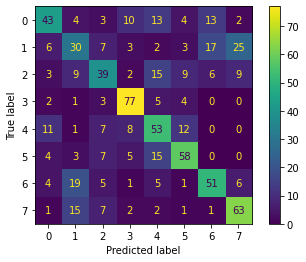

In [102]:
loaded_model = load('../Downloads/gscv_model_450_pca_f1_weighted.joblib')
y_true = y_test
y_pred = loaded_model.predict(X_test)
print(classification_report(y_true, y_pred, target_names=target_names))
cm = confusion_matrix(y_true, y_pred, labels=loaded_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=loaded_model.classes_)
disp.plot()
plt.show()

In [112]:
loaded_model = load('../Downloads/gscv_model_1250_pca_f1_weighted.joblib')
experiment = Experiment(project_name="audio_classification",
                            workspace="annkash",
                            api_key="lN5LpQvmYz3MYRVdRxpAN6Jn9")
experiment.set_name(f'XGBoost, test 1250 components')
experiment.add_tags(['test'])

y_true = y_test
y_pred = model.predict(X_test)
cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
experiment.log_confusion_matrix(y_true, y_pred)
experiment.log_parameters(loaded_model.get_params())
experiment.log_metrics({'precision_macro': precision_score(y_true, y_pred, average='macro'),
                       'accuracy': accuracy_score(y_true, y_pred),
                       'recall_macro': recall_score(y_true, y_pred, average='macro'),
                       'f1_macro': f1_score(y_true, y_pred, average='macro')})
experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Анна\\Downloads' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/annkash/audio-classification/92509669844f440dbd7f28bd027adc11

COMET WARNING: Experiment was interrupted by user while waiting for the initial data logger to be flushed.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:   

In [81]:
loaded_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
#Начало работы с аугментационными данными

In [17]:
df_augmented = pd.read_csv('../Downloads/reverb_noise.csv')
df_augmented['emotion_class'] = classes
df_augmented

,Unnamed: 0,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,emotion_class
0,0,2.827898,0.499554,0.0,1.072510,1.447448,1.677632,0.374938,0.230184,0.605122,...,0.542167,2.101617,2.100647,20.000000,0.660444,99.686264,50.040140,100.107635,50.060990,bored
1,1,1.868351,0.417298,0.0,0.592533,0.675752,0.768242,0.083219,0.092490,0.175710,...,0.527445,1.806191,1.807248,-19.999998,0.615610,80.784490,42.341778,80.861280,44.825770,bored
2,2,3.123350,0.786893,0.0,1.555560,1.874059,2.203131,0.318499,0.329072,0.647571,...,0.505884,2.289091,2.288518,20.000000,0.570562,98.758990,55.790787,95.821480,49.178430,happy
3,3,3.257999,0.450513,0.0,1.264659,1.624855,2.073868,0.360196,0.449013,0.809209,...,0.468312,2.039938,2.038015,19.999931,0.612930,88.946640,46.387836,85.378494,46.945553,anger
4,4,2.388086,0.107620,0.0,0.922923,1.102255,1.362300,0.179332,0.260045,0.439376,...,0.540635,1.720425,1.721979,-19.999947,0.534359,78.664790,39.981003,79.846390,40.411617,happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,1797,2.013077,0.217537,0.0,0.481199,0.644547,0.875237,0.163348,0.230690,0.394038,...,0.602100,1.998037,1.998734,-20.000000,0.503089,77.149220,48.645000,82.350020,47.064390,contentment
1798,1798,3.847205,0.434850,0.0,0.734311,1.211143,1.974263,0.476833,0.763120,1.239952,...,0.560393,2.461262,2.460593,20.000000,0.536380,106.984660,59.774387,105.647736,55.157680,anger
1799,1799,1.829345,0.672021,0.0,0.539745,0.726539,0.934346,0.186794,0.207807,0.394601,...,0.582342,2.556039,2.557246,-20.000000,0.521597,106.488106,59.142430,101.557335,55.586292,contentment
1800,1800,3.382777,0.563141,0.0,1.760422,1.969390,2.275210,0.208968,0.305820,0.514788,...,0.495575,2.000299,2.001739,-19.999989,0.609401,87.490920,44.893080,87.104330,45.151485,anger


In [287]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['emotion_class'])
df_augmented_y = label_encoder.transform(df_augmented['emotion_class'])

In [288]:
df_augmented_X = df_augmented.drop(['Unnamed: 0','emotion_class'], axis=1)
X = df.drop(['song_id','emotion_class'], axis=1)
df_augmented_X

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,2.827898,0.499554,0.0,1.072510,1.447448,1.677632,0.374938,0.230184,0.605122,0.501638,...,7.795220,0.542167,2.101617,2.100647,20.000000,0.660444,99.686264,50.040140,100.107635,50.060990
1,1.868351,0.417298,0.0,0.592533,0.675752,0.768242,0.083219,0.092490,0.175710,0.342667,...,6.550516,0.527445,1.806191,1.807248,-19.999998,0.615610,80.784490,42.341778,80.861280,44.825770
2,3.123350,0.786893,0.0,1.555560,1.874059,2.203131,0.318499,0.329072,0.647571,0.421987,...,9.209797,0.505884,2.289091,2.288518,20.000000,0.570562,98.758990,55.790787,95.821480,49.178430
3,3.257999,0.450513,0.0,1.264659,1.624855,2.073868,0.360196,0.449013,0.809209,0.670980,...,7.285163,0.468312,2.039938,2.038015,19.999931,0.612930,88.946640,46.387836,85.378494,46.945553
4,2.388086,0.107620,0.0,0.922923,1.102255,1.362300,0.179332,0.260045,0.439376,0.615370,...,6.806788,0.540635,1.720425,1.721979,-19.999947,0.534359,78.664790,39.981003,79.846390,40.411617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,2.013077,0.217537,0.0,0.481199,0.644547,0.875237,0.163348,0.230690,0.394038,0.206239,...,10.161247,0.602100,1.998037,1.998734,-20.000000,0.503089,77.149220,48.645000,82.350020,47.064390
1798,3.847205,0.434850,0.0,0.734311,1.211143,1.974263,0.476833,0.763120,1.239952,0.263146,...,9.410370,0.560393,2.461262,2.460593,20.000000,0.536380,106.984660,59.774387,105.647736,55.157680
1799,1.829345,0.672021,0.0,0.539745,0.726539,0.934346,0.186794,0.207807,0.394601,0.205494,...,11.747438,0.582342,2.556039,2.557246,-20.000000,0.521597,106.488106,59.142430,101.557335,55.586292
1800,3.382777,0.563141,0.0,1.760422,1.969390,2.275210,0.208968,0.305820,0.514788,0.713400,...,7.181194,0.495575,2.000299,2.001739,-19.999989,0.609401,87.490920,44.893080,87.104330,45.151485


In [289]:
#приведение названий признаков к виду, что принимает xgboost
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df_augmented_X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df_augmented_X.columns.values]
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [290]:
X, X_test, y, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 10)

In [291]:
#замена выбросов в исходных данных на 99 перцентиль
replace = np.percentile(X, 99, axis=0)
for i in range(X.shape[1]):
    X.iloc[:,i][X.iloc[:,i] > replace[i]] = replace[i]

In [292]:
#замена выбросов в аугментированных данных на 99 перцентиль
replace = np.percentile(df_augmented_X, 99, axis=0)
for i in range(df_augmented_X.shape[1]):
    df_augmented_X.iloc[:,i][df_augmented_X.iloc[:,i] > replace[i]] = replace[i]

In [293]:
X_aug_orig = pd.concat([X, df_augmented_X], ignore_index=True)
y_aug_orig = np.concatenate((y, df_augmented_y), axis=None)
X_aug_orig

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de_14__peakRangeAbs,mfcc_sma_de_14__peakRangeRel,mfcc_sma_de_14__peakMeanAbs,mfcc_sma_de_14__peakMeanMeanDist,mfcc_sma_de_14__peakMeanRel,mfcc_sma_de_14__minRangeRel,mfcc_sma_de_14__meanRisingSlope,mfcc_sma_de_14__stddevRisingSlope,mfcc_sma_de_14__meanFallingSlope,mfcc_sma_de_14__stddevFallingSlope
0,6.424580,0.332963,0.000000,3.332748,3.903018,4.421264,0.570270,0.518245,1.088515,0.337515,...,6.732283,0.582593,1.930457,1.932029,-19.999973,0.586350,91.302620,43.029570,89.600130,45.332157
1,2.456837,0.561610,0.000000,0.961971,1.344703,1.735996,0.382732,0.391293,0.774025,0.696549,...,5.950099,0.576178,1.487188,1.485494,19.999773,0.489115,72.904945,38.327652,75.544655,42.338715
2,8.086825,0.446099,0.000000,3.582904,4.016949,4.377657,0.434046,0.360708,0.794753,2.510154,...,8.078082,0.573312,2.017084,2.013926,19.998695,0.582696,90.659660,51.408722,86.044230,49.369198
3,4.075876,0.887603,0.618073,1.743976,2.232864,2.755840,0.488888,0.522976,1.011864,0.851803,...,9.088265,0.643786,2.358363,2.358705,-20.000000,0.518626,107.495255,56.039500,103.881870,50.909680
4,2.124113,0.949700,0.908524,0.778572,0.900874,1.161850,0.122302,0.260976,0.383277,0.641129,...,6.291827,0.491032,1.976850,1.975585,19.999996,0.640858,94.125830,47.418674,92.776405,48.706993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3058,2.013077,0.217537,0.000000,0.481199,0.644547,0.875237,0.163348,0.230690,0.394038,0.206239,...,10.161247,0.602100,1.998037,1.998734,-20.000000,0.503089,77.149220,48.645000,82.350020,47.064390
3059,3.847205,0.434850,0.000000,0.734311,1.211143,1.974263,0.476833,0.763120,1.239952,0.263146,...,9.410370,0.560393,2.461262,2.460593,20.000000,0.536380,106.984660,59.774387,105.647736,55.157680
3060,1.829345,0.672021,0.000000,0.539745,0.726539,0.934346,0.186794,0.207807,0.394601,0.205494,...,11.747438,0.582342,2.556039,2.557246,-20.000000,0.521597,106.488106,59.142430,101.557335,55.586292
3061,3.382777,0.563141,0.000000,1.760422,1.969390,2.275210,0.208968,0.305820,0.514788,0.713400,...,7.181194,0.495575,2.000299,2.001739,-19.999989,0.609401,87.490920,44.893080,87.104330,45.151485


In [297]:
#поиск признаков с корреляцией более 0.7
threshold = 0.7
col_corr = set()  
corr_matrix = X_aug_orig.corr(method='spearman')
for i in tqdm.tqdm(range(len(corr_matrix.columns))):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold: 
            colname = corr_matrix.columns[i]  
            col_corr.add(colname)
corr_features = col_corr


 12%|█████████▍                                                                     | 765/6373 [01:33<06:30, 14.35it/s]


 20%|███████████████▎                                                              | 1254/6373 [02:11<03:50, 22.16it/s]


 25%|███████████████████▌                                                          | 1603/6373 [02:38<04:33, 17.47it/s]


 31%|███████████████████████▉                                                      | 1954/6373 [03:03<08:19,  8.85it/s]


 36%|████████████████████████████                                                  | 2289/6373 [03:30<07:32,  9.02it/s]


 41%|███████████████████████████████▊                                              | 2600/6373 [04:01<04:52, 12.92it/s]


 45%|███████████████████████████████████                                           | 2869/6373 [04:21<03:04, 19.00it/s]


 49%|██████████████████████████████████████▎                                       | 3133/6373 [04:37<03:10, 16.99it/s]


 53%|█████████████████████████████████████████▌                                    | 3393/6373 [17:03<05:46,  8.60it/s]


 57%|████████████████████████████████████████████▊                                 | 3657/6373 [17:25<03:24, 13.27it/s]


 62%|███████████████████████████████████████████████▉                              | 3921/6373 [17:49<03:56, 10.36it/s]


 65%|██████████████████████████████████████████████████▉                           | 4166/6373 [18:18<04:06,  8.96it/s]


 69%|█████████████████████████████████████████████████████▊                        | 4394/6373 [18:44<03:46,  8.74it/s]


 73%|████████████████████████████████████████████████████████▊                     | 4640/6373 [19:12<03:01,  9.56it/s]


 76%|███████████████████████████████████████████████████████████▌                  | 4866/6373 [19:41<03:08,  8.00it/s]


 80%|██████████████████████████████████████████████████████████████▏               | 5080/6373 [20:08<02:34,  8.36it/s]


 83%|████████████████████████████████████████████████████████████████▌             | 5276/6373 [20:33<03:01,  6.04it/s]


 85%|██████████████████████████████████████████████████████████████████▎           | 5421/6373 [20:58<02:52,  5.50it/s]


 87%|████████████████████████████████████████████████████████████████████          | 5556/6373 [21:17<01:26,  9.41it/s]


 89%|█████████████████████████████████████████████████████████████████████▌        | 5688/6373 [21:35<01:13,  9.30it/s]


 91%|███████████████████████████████████████████████████████████████████████▏      | 5820/6373 [21:51<01:02,  8.85it/s]


 93%|████████████████████████████████████████████████████████████████████████▊     | 5952/6373 [22:14<00:52,  8.07it/s]


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6084/6373 [22:33<00:40,  7.18it/s]


 98%|████████████████████████████████████████████████████████████████████████████  | 6216/6373 [22:55<00:44,  3.49it/s]


100%|█████████████████████████████████████████████████████████████████████████████▋| 6348/6373 [23:25<00:03,  8.27it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 6373/6373 [23:29<00:00,  4.52it/s]


In [298]:
len(set(corr_features))

5453

In [299]:
import pickle
with open("corr_features_0.7", "wb") as fp:   #Pickling
    pickle.dump(corr_features, fp)

In [20]:
#with open("corr_features_0.7", "rb") as fp:   # Unpickling  
#    corr_features = pickle.load(fp)

In [154]:
corr_features

{'pcm_fftMag_spectralSkewness_sma_de_segLenStddev',
 'audSpec_Rfilt_sma_de_9__stddevRisingSlope',
 'logHNR_sma_de_qregerrQ',
 'mfcc_sma_de_12__lpc0',
 'audSpec_Rfilt_sma_22__range',
 'audSpec_Rfilt_sma_de_3__percentile99.0',
 'pcm_fftMag_spectralRollOff50.0_sma_de_lpc2',
 'audSpec_Rfilt_sma_24__lpc4',
 'audSpec_Rfilt_sma_2__lpc2',
 'audSpec_Rfilt_sma_25__percentile99.0',
 'audspecRasta_lengthL1norm_sma_stddevFallingSlope',
 'pcm_zcr_sma_pctlrange0-1',
 'pcm_zcr_sma_de_posamean',
 'audSpec_Rfilt_sma_17__quartile2',
 'pcm_fftMag_spectralSkewness_sma_de_rqmean',
 'audSpec_Rfilt_sma_24__stddev',
 'audSpec_Rfilt_sma_de_4__lpc3',
 'audSpec_Rfilt_sma_7__iqr2-3',
 'audSpec_Rfilt_sma_12__lpc0',
 'audSpec_Rfilt_sma_de_9__percentile99.0',
 'audspecRasta_lengthL1norm_sma_de_minSegLen',
 'pcm_fftMag_psySharpness_sma_segLenStddev',
 'audSpec_Rfilt_sma_10__stddevFallingSlope',
 'audSpec_Rfilt_sma_de_19__stddev',
 'audSpec_Rfilt_sma_de_5__peakMeanAbs',
 'audSpec_Rfilt_sma_21__stddevRisingSlope',
 'aud

In [300]:
#подсчёт коэффициентов корреляции и p-значений между выбранными сильно скоррелированными признаками и таргетом
import scipy.stats
new_corrs = []
target = pd.Series(y_aug_orig)
# Iterate through the columns 
for col in corr_features:
    # Calculate correlation with the target
    res = scipy.stats.spearmanr(X_aug_orig[col], target)
    corr = res.correlation
    if (res.pvalue < 0.05):
        new_corrs.append((col, corr, bool(True)))
    else:
        new_corrs.append((col, corr, bool(False)))

In [301]:
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs

[('pcm_fftMag_spectralCentroid_sma_maxSegLen', 0.12787398584888657, True),
 ('mfcc_sma_de_14__peakDistStddev', 0.12080062917817402, True),
 ('pcm_fftMag_spectralCentroid_sma_segLenStddev', 0.12032327233931892, True),
 ('mfcc_sma_de_14__meanPeakDist', 0.1189610286274093, True),
 ('pcm_fftMag_spectralCentroid_sma_meanSegLen', 0.11890148751340934, True),
 ('mfcc_sma_de_14__kurtosis', 0.11756418512792881, True),
 ('pcm_fftMag_psySharpness_sma_peakDistStddev', 0.11725852279151237, True),
 ('pcm_fftMag_fband1000-4000_sma_de_flatness', -0.11493260989211085, True),
 ('pcm_fftMag_spectralHarmonicity_sma_peakMeanRel', 0.11392900556245744, True),
 ('pcm_fftMag_fband1000-4000_sma_percentile1.0', -0.11358220065232907, True),
 ('pcm_fftMag_spectralHarmonicity_sma_de_flatness', -0.1131957734903679, True),
 ('audspec_lengthL1norm_sma_de_peakDistStddev', 0.11318917570854815, True),
 ('mfcc_sma_8__peakDistStddev', 0.11302823837843197, True),
 ('mfcc_sma_7__peakDistStddev', 0.11293070164695547, True),
 (

In [302]:
#удаление сильно скоррелированных признаков
X_aug_orig.drop(corr_features, axis=1, inplace=True)
X_test.drop(corr_features, axis=1, inplace=True)
X.drop(corr_features, axis=1, inplace=True)
df_augmented_X.drop(corr_features, axis=1, inplace=True)

In [303]:
#центрирование и масштабирование
scaler = StandardScaler()
cols = X_aug_orig.columns
X_aug_orig = pd.DataFrame(scaler.fit_transform(X_aug_orig), columns=cols)
X_test = pd.DataFrame(scaler.transform(X_test), columns=cols)
X = pd.DataFrame(scaler.transform(X), columns=cols)
df_augmented_X = pd.DataFrame(scaler.transform(df_augmented_X), columns=cols)

In [45]:
#снижение размерности(использовалось для поиска метрики)
model_pca_aug_orig = PCA(0.99)
X_aug_orig = model_pca_aug_orig.fit_transform(X_aug_orig)
X_test = model_pca_aug_orig.transform(X_test)
X_aug = model_pca_aug_orig.transform(df_augmented_X)
X = model_pca_aug_orig.transform(X)

In [307]:
#целевая функция, принимающая аугментированные данные
def objective_aug(trial, X, X_aug, y, y_aug):
    
    params_grid = {
        "objective": trial.suggest_categorical('objective', ['multi:softprob', 'multi:softmax'] ),
        "n_estimators": trial.suggest_int('n_estimators', low=10, high=300, step=30),
        "learning_rate": trial.suggest_float("learning_rate", low=0.01, high=0.1, step=0.01),
        "max_depth": trial.suggest_int("max_depth", low=1, high=8, step=1),
        #"subsample": trial.suggest_float("subsample", low=0.05, high=1.0, step=0.2),
        #"colsample_bytree": trial.suggest_float("colsample_bytree", low=0.05, high=1.0, step=0.2),
        "min_child_weight": trial.suggest_int("min_child_weight", low=1, high=21, step=2),
        'lambda': trial.suggest_float("lambda", low=0, high=1, step=0.1),
        'alpha': trial.suggest_float("alpha", low=0, high=1, step=0.1),
        'gamma': trial.suggest_float("gamma", low=0, high=1, step=0.1),
        #'colsample_bylevel': trial.suggest_float("colsample_bylevel", low=0.05, high=1.0, step=0.1),
        'seed': trial.suggest_int("seed", low=10, high=10)
    }
    
    kf = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
    
    cv_predicts = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        X_train = pd.concat([X_train, X_aug])
        y_train = np.concatenate((y_train, y_aug), axis=None)
        
        undersample = RandomUnderSampler(random_state=10)
        X_train_undersample, y_train_undersample = undersample.fit_resample(X_train, y_train)
        
        model = xgb.XGBClassifier(**params_grid)
        
        if (idx == 0):
            pruning_callback = XGBoostPruningCallback(trial, 'validation_0-merror')
            model.fit(X_train_undersample, y_train_undersample, 
                      eval_set=[(X_test, y_test)], 
                      eval_metric='merror',
                      verbose = 0,
                      callbacks=[pruning_callback]
                     )
        else:
            model.fit(X_train_undersample, y_train_undersample, 
                      eval_set=[(X_test, y_test)], 
                      eval_metric='merror',
                      verbose = 0
                     )
            
        y_pred = model.predict(X_test)
        cv_predicts[idx] = recall_score(y_test, y_pred, average='macro')
    
    return np.mean(cv_predicts)

In [305]:
def objective(trial, X, y):

    params_grid = {
        "objective": trial.suggest_categorical('objective', ['multi:softprob', 'multi:softmax'] ),
        "n_estimators": trial.suggest_int('n_estimators', low=10, high=310, step=100),
        "learning_rate": trial.suggest_float("learning_rate", low=0.01, high=0.1, step=0.02),
        "max_depth": trial.suggest_int("max_depth", low=1, high=6, step=1),
        #"subsample": trial.suggest_float("subsample", low=0.05, high=1.0, step=0.2),
        #"colsample_bytree": trial.suggest_float("colsample_bytree", low=0.05, high=1.0, step=0.2),
        "min_child_weight": trial.suggest_int("min_child_weight", low=1, high=21, step=2),
        'lambda': trial.suggest_float("lambda", low=0, high=1, step=0.1),
        'alpha': trial.suggest_float("alpha", low=0, high=1, step=0.1),
        'gamma': trial.suggest_float("gamma", low=0, high=1, step=0.1),
        #'colsample_bylevel': trial.suggest_float("colsample_bylevel", low=0.05, high=1.0, step=0.1),
        'seed': trial.suggest_int("seed", low=10, high=10)
    }
    
    kf = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
    
    cv_predicts = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        oversample = RandomOverSampler(random_state=10, sampling_strategy='not majority')
        X_train_oversample, y_train_oversample = oversample.fit_resample(X_train, y_train)
        
        model = xgb.XGBClassifier(**params_grid)
        
        if (idx == 0):
            pruning_callback = XGBoostPruningCallback(trial, 'validation_0-merror')
            model.fit(X_train_oversample, y_train_oversample, 
                      eval_set=[(X_test, y_test)], 
                      eval_metric='merror',
                      verbose = 0,
                      callbacks=[pruning_callback]
                     )
        else:
            model.fit(X_train_oversample, y_train_oversample, 
                      eval_set=[(X_test, y_test)], 
                      eval_metric='merror',
                      verbose = 0
                     )
        
        y_pred = model.predict(X_test)
        cv_predicts[idx] = recall_score(y_test, y_pred, average='macro')
    
    return np.mean(cv_predicts)

In [308]:
import optuna
import warnings
warnings.filterwarnings('ignore')
n_train_iter = 100

#поиск гиперпараметров с optuna
study = create_study(direction='maximize', study_name='xgb_classifier', pruner=optuna.pruners.HyperbandPruner(
    min_resource=1, max_resource=n_train_iter, reduction_factor=3))
func = lambda trial: objective_aug(trial, X, df_augmented_X, y, df_augmented_y)
study.optimize(func, n_trials=100, show_progress_bar=True)

[I 2024-03-15 10:09:58,633] A new study created in memory with name: xgb_classifier


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|                                                                                         | 0/6373 [56:00<?, ?it/s]

[I 2024-03-15 10:16:20,879] Trial 0 finished with value: 0.5985027875162966 and parameters: {'objective': 'multi:softmax', 'n_estimators': 190, 'learning_rate': 0.060000000000000005, 'max_depth': 6, 'min_child_weight': 19, 'lambda': 0.6000000000000001, 'alpha': 0.2, 'gamma': 0.2, 'seed': 10}. Best is trial 0 with value: 0.5985027875162966.


  0%|                                                                                       | 0/6373 [1:01:03<?, ?it/s]

[I 2024-03-15 10:21:23,971] Trial 1 finished with value: 0.5436612326297098 and parameters: {'objective': 'multi:softmax', 'n_estimators': 130, 'learning_rate': 0.04, 'max_depth': 7, 'min_child_weight': 19, 'lambda': 0.0, 'alpha': 0.6000000000000001, 'gamma': 0.6000000000000001, 'seed': 10}. Best is trial 0 with value: 0.5985027875162966.


  0%|                                                                                       | 0/6373 [1:01:04<?, ?it/s]

[I 2024-03-15 10:21:24,932] Trial 2 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:05:46<?, ?it/s]

[I 2024-03-15 10:26:07,051] Trial 3 finished with value: 0.5668597214429906 and parameters: {'objective': 'multi:softmax', 'n_estimators': 130, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 19, 'lambda': 0.30000000000000004, 'alpha': 0.0, 'gamma': 0.6000000000000001, 'seed': 10}. Best is trial 0 with value: 0.5985027875162966.


  0%|                                                                                       | 0/6373 [1:11:07<?, ?it/s]

[I 2024-03-15 10:31:27,846] Trial 4 finished with value: 0.5094455145399991 and parameters: {'objective': 'multi:softprob', 'n_estimators': 280, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 17, 'lambda': 0.7000000000000001, 'alpha': 0.4, 'gamma': 0.4, 'seed': 10}. Best is trial 0 with value: 0.5985027875162966.


  0%|                                                                                       | 0/6373 [1:11:08<?, ?it/s]

[I 2024-03-15 10:31:28,868] Trial 5 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:12:00<?, ?it/s]

[I 2024-03-15 10:32:20,743] Trial 6 finished with value: 0.2820293941672116 and parameters: {'objective': 'multi:softprob', 'n_estimators': 100, 'learning_rate': 0.02, 'max_depth': 1, 'min_child_weight': 13, 'lambda': 1.0, 'alpha': 1.0, 'gamma': 0.30000000000000004, 'seed': 10}. Best is trial 0 with value: 0.5985027875162966.


  0%|                                                                                       | 0/6373 [1:12:01<?, ?it/s]

[I 2024-03-15 10:32:22,504] Trial 7 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:13:25<?, ?it/s]

[I 2024-03-15 10:33:46,428] Trial 8 finished with value: 0.33234844245172396 and parameters: {'objective': 'multi:softmax', 'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 5, 'lambda': 0.7000000000000001, 'alpha': 0.8, 'gamma': 0.6000000000000001, 'seed': 10}. Best is trial 0 with value: 0.5985027875162966.


  0%|                                                                                       | 0/6373 [1:13:29<?, ?it/s]

[I 2024-03-15 10:33:50,132] Trial 9 pruned. Trial was pruned at iteration 9.


  0%|                                                                                       | 0/6373 [1:13:39<?, ?it/s]

[I 2024-03-15 10:33:59,680] Trial 10 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:13:42<?, ?it/s]

[I 2024-03-15 10:34:02,887] Trial 11 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:13:47<?, ?it/s]

[I 2024-03-15 10:34:07,647] Trial 12 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:13:50<?, ?it/s]

[I 2024-03-15 10:34:10,997] Trial 13 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:13:53<?, ?it/s]

[I 2024-03-15 10:34:13,775] Trial 14 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:13:55<?, ?it/s]

[I 2024-03-15 10:34:16,512] Trial 15 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:16:43<?, ?it/s]

[I 2024-03-15 10:37:03,776] Trial 16 finished with value: 0.537090762012965 and parameters: {'objective': 'multi:softmax', 'n_estimators': 70, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 9, 'lambda': 0.8, 'alpha': 0.0, 'gamma': 0.8, 'seed': 10}. Best is trial 0 with value: 0.5985027875162966.


  0%|                                                                                       | 0/6373 [1:16:45<?, ?it/s]

[I 2024-03-15 10:37:06,465] Trial 17 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:16:47<?, ?it/s]

[I 2024-03-15 10:37:07,741] Trial 18 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:16:49<?, ?it/s]

[I 2024-03-15 10:37:09,656] Trial 19 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:16:51<?, ?it/s]

[I 2024-03-15 10:37:12,045] Trial 20 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:16:53<?, ?it/s]

[I 2024-03-15 10:37:13,740] Trial 21 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:22:51<?, ?it/s]

[I 2024-03-15 10:43:12,060] Trial 22 finished with value: 0.5243518531401106 and parameters: {'objective': 'multi:softmax', 'n_estimators': 160, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 19, 'lambda': 0.1, 'alpha': 0.6000000000000001, 'gamma': 0.5, 'seed': 10}. Best is trial 0 with value: 0.5985027875162966.


  0%|                                                                                       | 0/6373 [1:23:25<?, ?it/s]

[I 2024-03-15 10:43:45,939] Trial 23 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:23:27<?, ?it/s]

[I 2024-03-15 10:43:47,972] Trial 24 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:23:30<?, ?it/s]

[I 2024-03-15 10:43:50,758] Trial 25 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:23:44<?, ?it/s]

[I 2024-03-15 10:44:04,724] Trial 26 pruned. Trial was pruned at iteration 27.


  0%|                                                                                       | 0/6373 [1:23:47<?, ?it/s]

[I 2024-03-15 10:44:07,889] Trial 27 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:23:50<?, ?it/s]

[I 2024-03-15 10:44:11,101] Trial 28 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:23:52<?, ?it/s]

[I 2024-03-15 10:44:13,215] Trial 29 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:23:55<?, ?it/s]

[I 2024-03-15 10:44:16,293] Trial 30 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:26:50<?, ?it/s]

[I 2024-03-15 10:47:10,760] Trial 31 finished with value: 0.5449705265351454 and parameters: {'objective': 'multi:softmax', 'n_estimators': 70, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 7, 'lambda': 0.8, 'alpha': 0.0, 'gamma': 0.8, 'seed': 10}. Best is trial 0 with value: 0.5985027875162966.


  0%|                                                                                       | 0/6373 [1:26:52<?, ?it/s]

[I 2024-03-15 10:47:13,370] Trial 32 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:26:55<?, ?it/s]

[I 2024-03-15 10:47:16,390] Trial 33 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:26:59<?, ?it/s]

[I 2024-03-15 10:47:19,594] Trial 34 pruned. Trial was pruned at iteration 9.


  0%|                                                                                       | 0/6373 [1:27:01<?, ?it/s]

[I 2024-03-15 10:47:21,692] Trial 35 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:27:05<?, ?it/s]

[I 2024-03-15 10:47:25,910] Trial 36 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:27:06<?, ?it/s]

[I 2024-03-15 10:47:27,089] Trial 37 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:27:09<?, ?it/s]

[I 2024-03-15 10:47:29,617] Trial 38 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:27:10<?, ?it/s]

[I 2024-03-15 10:47:30,911] Trial 39 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:30:18<?, ?it/s]

[I 2024-03-15 10:50:38,890] Trial 40 finished with value: 0.46389164860089177 and parameters: {'objective': 'multi:softmax', 'n_estimators': 160, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 13, 'lambda': 0.4, 'alpha': 0.30000000000000004, 'gamma': 0.7000000000000001, 'seed': 10}. Best is trial 0 with value: 0.5985027875162966.


  0%|                                                                                       | 0/6373 [1:30:20<?, ?it/s]

[I 2024-03-15 10:50:41,216] Trial 41 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:30:23<?, ?it/s]

[I 2024-03-15 10:50:44,519] Trial 42 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:30:26<?, ?it/s]

[I 2024-03-15 10:50:47,205] Trial 43 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:33:32<?, ?it/s]

[I 2024-03-15 10:53:52,962] Trial 44 finished with value: 0.5541357110829619 and parameters: {'objective': 'multi:softmax', 'n_estimators': 70, 'learning_rate': 0.060000000000000005, 'max_depth': 6, 'min_child_weight': 11, 'lambda': 0.9, 'alpha': 1.0, 'gamma': 1.0, 'seed': 10}. Best is trial 0 with value: 0.5985027875162966.


  0%|                                                                                       | 0/6373 [1:33:35<?, ?it/s]

[I 2024-03-15 10:53:55,934] Trial 45 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:33:49<?, ?it/s]

[I 2024-03-15 10:54:09,562] Trial 46 pruned. Trial was pruned at iteration 27.


  0%|                                                                                       | 0/6373 [1:33:53<?, ?it/s]

[I 2024-03-15 10:54:13,631] Trial 47 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:34:51<?, ?it/s]

[I 2024-03-15 10:55:12,270] Trial 48 pruned. Trial was pruned at iteration 81.


  0%|                                                                                       | 0/6373 [1:34:54<?, ?it/s]

[I 2024-03-15 10:55:15,217] Trial 49 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:34:57<?, ?it/s]

[I 2024-03-15 10:55:18,214] Trial 50 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:35:00<?, ?it/s]

[I 2024-03-15 10:55:21,323] Trial 51 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:35:04<?, ?it/s]

[I 2024-03-15 10:55:25,354] Trial 52 pruned. Trial was pruned at iteration 9.


  0%|                                                                                       | 0/6373 [1:35:06<?, ?it/s]

[I 2024-03-15 10:55:27,432] Trial 53 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:35:09<?, ?it/s]

[I 2024-03-15 10:55:29,950] Trial 54 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:35:15<?, ?it/s]

[I 2024-03-15 10:55:35,609] Trial 55 pruned. Trial was pruned at iteration 9.


  0%|                                                                                       | 0/6373 [1:35:30<?, ?it/s]

[I 2024-03-15 10:55:50,734] Trial 56 pruned. Trial was pruned at iteration 27.


  0%|                                                                                       | 0/6373 [1:35:32<?, ?it/s]

[I 2024-03-15 10:55:53,119] Trial 57 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:35:33<?, ?it/s]

[I 2024-03-15 10:55:54,466] Trial 58 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:35:35<?, ?it/s]

[I 2024-03-15 10:55:55,937] Trial 59 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:35:43<?, ?it/s]

[I 2024-03-15 10:56:03,585] Trial 60 pruned. Trial was pruned at iteration 9.


  0%|                                                                                       | 0/6373 [1:35:46<?, ?it/s]

[I 2024-03-15 10:56:06,592] Trial 61 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:35:49<?, ?it/s]

[I 2024-03-15 10:56:09,781] Trial 62 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:35:54<?, ?it/s]

[I 2024-03-15 10:56:14,820] Trial 63 pruned. Trial was pruned at iteration 27.


  0%|                                                                                       | 0/6373 [1:35:57<?, ?it/s]

[I 2024-03-15 10:56:17,588] Trial 64 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:35:58<?, ?it/s]

[I 2024-03-15 10:56:19,209] Trial 65 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:36:00<?, ?it/s]

[I 2024-03-15 10:56:21,035] Trial 66 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:36:05<?, ?it/s]

[I 2024-03-15 10:56:26,328] Trial 67 pruned. Trial was pruned at iteration 9.


  0%|                                                                                       | 0/6373 [1:36:07<?, ?it/s]

[I 2024-03-15 10:56:28,123] Trial 68 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:36:10<?, ?it/s]

[I 2024-03-15 10:56:30,780] Trial 69 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:36:12<?, ?it/s]

[I 2024-03-15 10:56:33,390] Trial 70 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:36:15<?, ?it/s]

[I 2024-03-15 10:56:35,643] Trial 71 pruned. Trial was pruned at iteration 9.


  0%|                                                                                       | 0/6373 [1:42:47<?, ?it/s]

[I 2024-03-15 11:03:08,445] Trial 72 finished with value: 0.5491374693139237 and parameters: {'objective': 'multi:softprob', 'n_estimators': 250, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 17, 'lambda': 0.8, 'alpha': 0.4, 'gamma': 0.4, 'seed': 10}. Best is trial 0 with value: 0.5985027875162966.


  0%|                                                                                       | 0/6373 [1:42:50<?, ?it/s]

[I 2024-03-15 11:03:10,739] Trial 73 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:42:53<?, ?it/s]

[I 2024-03-15 11:03:14,520] Trial 74 pruned. Trial was pruned at iteration 9.


  0%|                                                                                       | 0/6373 [1:42:56<?, ?it/s]

[I 2024-03-15 11:03:17,036] Trial 75 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:42:58<?, ?it/s]

[I 2024-03-15 11:03:18,932] Trial 76 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:43:00<?, ?it/s]

[I 2024-03-15 11:03:21,415] Trial 77 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:43:15<?, ?it/s]

[I 2024-03-15 11:03:36,503] Trial 78 pruned. Trial was pruned at iteration 27.


  0%|                                                                                       | 0/6373 [1:43:19<?, ?it/s]

[I 2024-03-15 11:03:40,168] Trial 79 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:43:23<?, ?it/s]

[I 2024-03-15 11:03:43,765] Trial 80 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:43:24<?, ?it/s]

[I 2024-03-15 11:03:45,270] Trial 81 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:43:29<?, ?it/s]

[I 2024-03-15 11:03:50,463] Trial 82 pruned. Trial was pruned at iteration 9.


  0%|                                                                                       | 0/6373 [1:43:32<?, ?it/s]

[I 2024-03-15 11:03:52,597] Trial 83 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:47:22<?, ?it/s]

[I 2024-03-15 11:07:43,384] Trial 84 finished with value: 0.3989645694568934 and parameters: {'objective': 'multi:softprob', 'n_estimators': 280, 'learning_rate': 0.02, 'max_depth': 2, 'min_child_weight': 21, 'lambda': 0.7000000000000001, 'alpha': 0.5, 'gamma': 0.5, 'seed': 10}. Best is trial 0 with value: 0.5985027875162966.


  0%|                                                                                       | 0/6373 [1:49:50<?, ?it/s]

[I 2024-03-15 11:10:10,742] Trial 85 finished with value: 0.42159337062359314 and parameters: {'objective': 'multi:softprob', 'n_estimators': 70, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 17, 'lambda': 0.8, 'alpha': 0.4, 'gamma': 0.6000000000000001, 'seed': 10}. Best is trial 0 with value: 0.5985027875162966.


  0%|                                                                                       | 0/6373 [1:49:55<?, ?it/s]

[I 2024-03-15 11:10:16,105] Trial 86 pruned. Trial was pruned at iteration 9.


  0%|                                                                                       | 0/6373 [1:50:13<?, ?it/s]

[I 2024-03-15 11:10:33,901] Trial 87 pruned. Trial was pruned at iteration 27.


  0%|                                                                                       | 0/6373 [1:50:16<?, ?it/s]

[I 2024-03-15 11:10:37,171] Trial 88 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:50:19<?, ?it/s]

[I 2024-03-15 11:10:40,131] Trial 89 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:50:20<?, ?it/s]

[I 2024-03-15 11:10:41,407] Trial 90 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:50:24<?, ?it/s]

[I 2024-03-15 11:10:45,525] Trial 91 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:50:26<?, ?it/s]

[I 2024-03-15 11:10:46,816] Trial 92 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:50:27<?, ?it/s]

[I 2024-03-15 11:10:47,883] Trial 93 pruned. Trial was pruned at iteration 1.


  0%|                                                                                       | 0/6373 [1:50:30<?, ?it/s]

[I 2024-03-15 11:10:50,935] Trial 94 pruned. Trial was pruned at iteration 9.


  0%|                                                                                       | 0/6373 [1:50:32<?, ?it/s]

[I 2024-03-15 11:10:53,454] Trial 95 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:50:38<?, ?it/s]

[I 2024-03-15 11:10:58,905] Trial 96 pruned. Trial was pruned at iteration 27.


  0%|                                                                                       | 0/6373 [1:50:45<?, ?it/s]

[I 2024-03-15 11:11:06,216] Trial 97 pruned. Trial was pruned at iteration 3.


  0%|                                                                                       | 0/6373 [1:51:03<?, ?it/s]

[I 2024-03-15 11:11:23,974] Trial 98 pruned. Trial was pruned at iteration 27.


  0%|                                                                                       | 0/6373 [1:51:08<?, ?it/s]

[I 2024-03-15 11:11:28,728] Trial 99 pruned. Trial was pruned at iteration 9.


In [309]:
print('best value: ', study.best_value)
print('best_params: ')
for key, value in study.best_params.items():
    print(key,":", value)

best value:  0.5985027875162966
best_params: 
objective : multi:softmax
n_estimators : 190
learning_rate : 0.060000000000000005
max_depth : 6
min_child_weight : 19
lambda : 0.6000000000000001
alpha : 0.2
gamma : 0.2
seed : 10


In [317]:
from comet_ml import ConfusionMatrix

X_train = pd.concat([X, df_augmented_X])
y_train = np.concatenate((y, df_augmented_y), axis=None)

undersample = RandomUnderSampler(random_state=10)
X_train_undersample, y_train_undersample = undersample.fit_resample(X_train, y_train)

experiment = Experiment(project_name="audio_classification",
                            workspace="annkash",
                            api_key="lN5LpQvmYz3MYRVdRxpAN6Jn9")
experiment.set_name(f'XGBoost, optuna params, -corr_features0.7')
experiment.add_tags(['test', 'recall', 'hyperband_pruner', 'undersampling', 'augmentation'])

model = xgb.XGBClassifier()
model.set_params(**study.best_params)
model.fit(X_train_undersample, y_train_undersample)
y_true = y_test
y_pred = model.predict(X_test)
labels = list(label_encoder.inverse_transform(model.classes_))
cm = ConfusionMatrix()
cm.compute_matrix(y_true, y_pred)
experiment.log_confusion_matrix(matrix=cm, labels=labels)
experiment.log_parameters(model.get_params())
experiment.log_metrics({'precision_macro': precision_score(y_true, y_pred, average='macro'),
                       'accuracy': accuracy_score(y_true, y_pred),
                       'recall_macro': recall_score(y_true, y_pred, average='macro'),
                       'f1_macro': f1_score(y_true, y_pred, average='macro')})
experiment.end()


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/annkash/audio-classification/0a083b84993140d39495d5629c64406f
COMET INFO:   Others:
COMET INFO:     Name : XGBoost, optuna params, -corr_features0.7
COMET INFO:   Parameters:
COMET INFO:     alpha            : 0.2
COMET INFO:     begin_iteration  : 0
COMET INFO:     end_iteration    : 189
COMET INFO:     gamma            : 0.2
COMET INFO:     lambda           : 0.6000000000000001
COMET INFO:     learning_rate    : 0.060000000000000005
COMET INFO:     max_depth        : 6
COMET INFO:     min_child_weight : 19
COMET INFO:     num_class        : 8
COMET INFO:     objective        : multi:softmax
COMET INFO:     rank             : 0

In [ ]:
#важность для модели без коррелированных признаков более 0.9

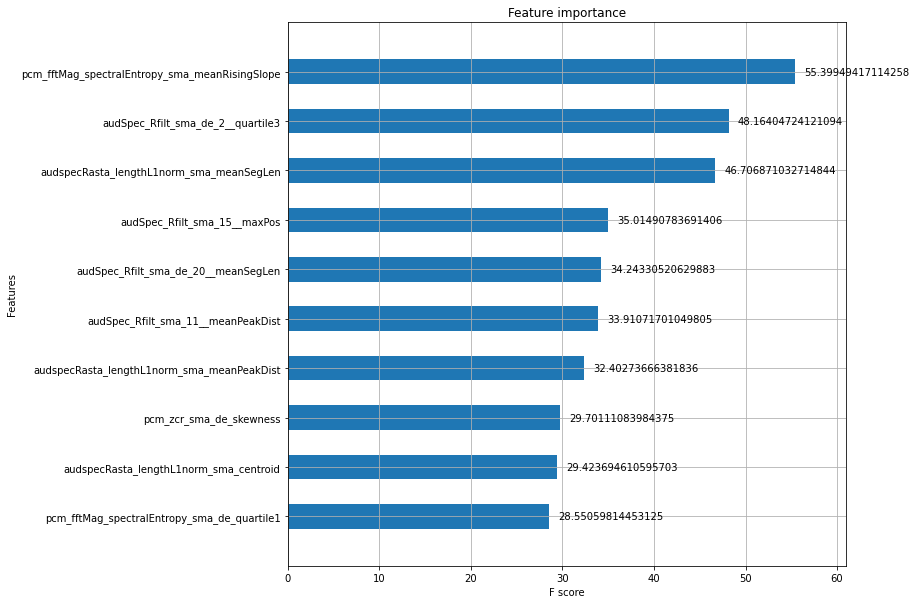

In [160]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, max_num_features=10, height=0.5, ax=ax,importance_type='gain')
plt.show()

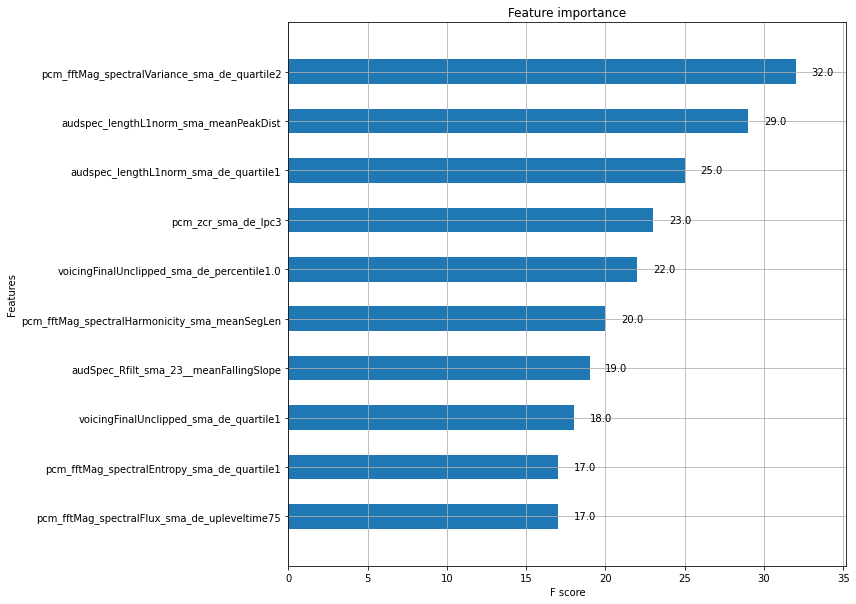

In [161]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, max_num_features=10, height=0.5, ax=ax,importance_type='weight')
plt.show()

In [175]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train_undersample)

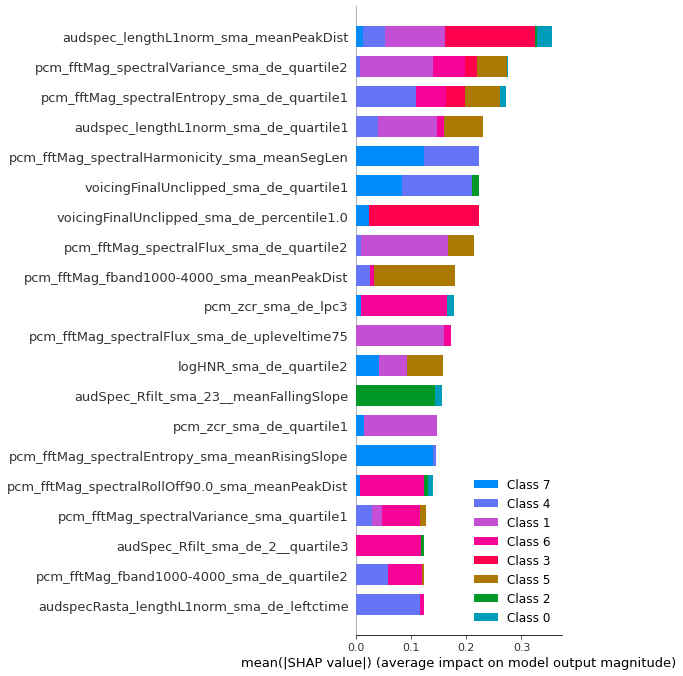

In [200]:
shap.summary_plot(
    [shap_values[:, :, class_ind].values for class_ind in range(shap_values.shape[-1])],
    feature_names=X_train_undersample.columns,
    plot_type="bar")


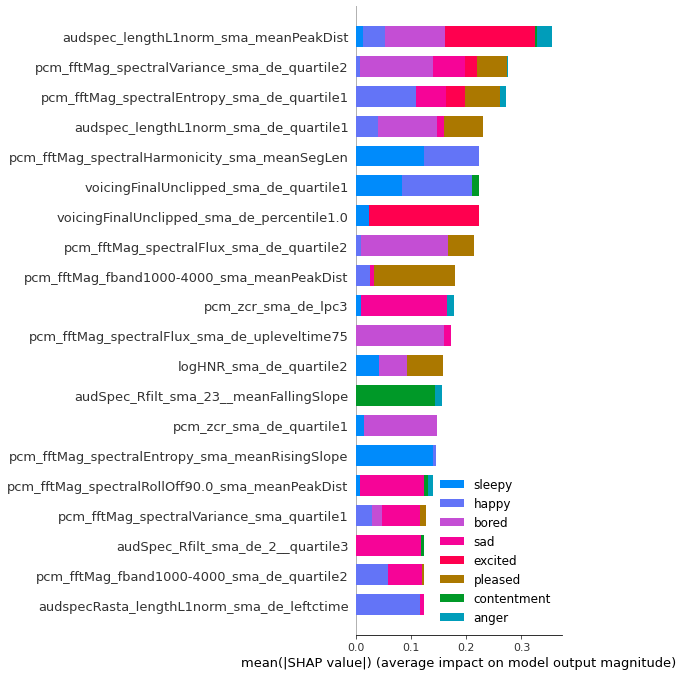

In [179]:
shap.summary_plot(
    [shap_values[:, :, class_ind].values for class_ind in range(shap_values.shape[-1])],
    feature_names=X_train_undersample.columns,
    plot_type="bar",
    class_names=label_encoder.inverse_transform(model.classes_)
)

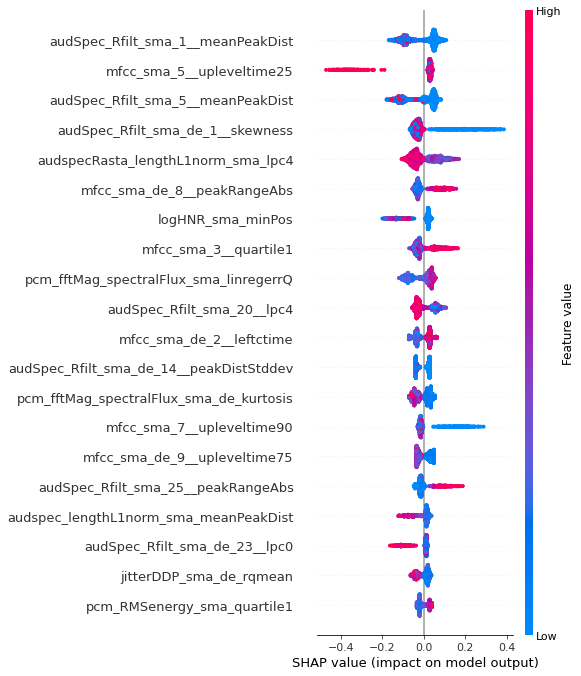

In [202]:
shap.summary_plot(shap_values[:, :, 0], feature_names=X_train_undersample.columns)

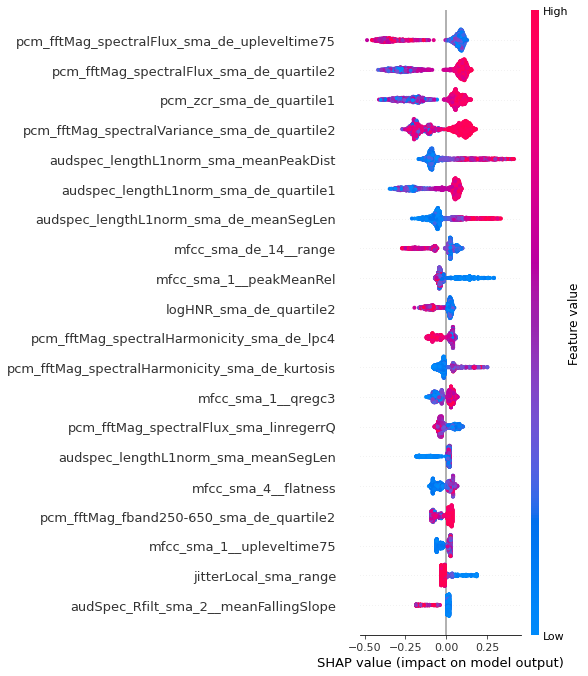

In [203]:
shap.summary_plot(shap_values[:, :, 1], feature_names=X_train_undersample.columns)

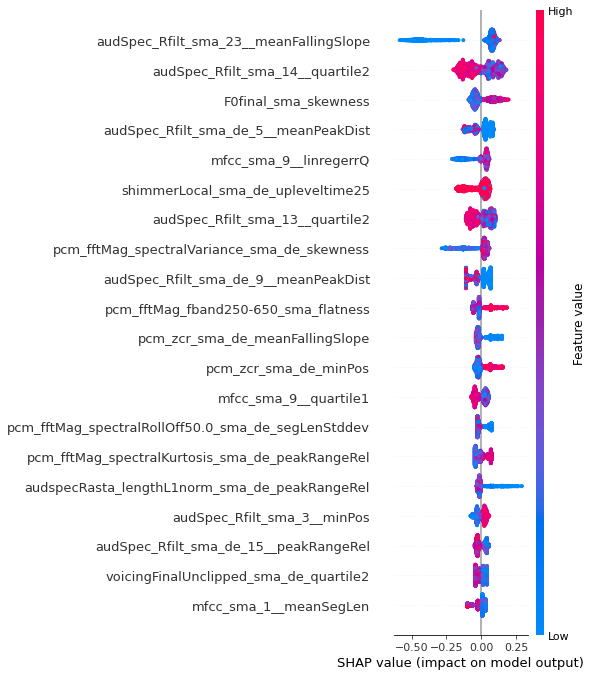

In [204]:
shap.summary_plot(shap_values[:, :, 2], feature_names=X_train_undersample.columns)

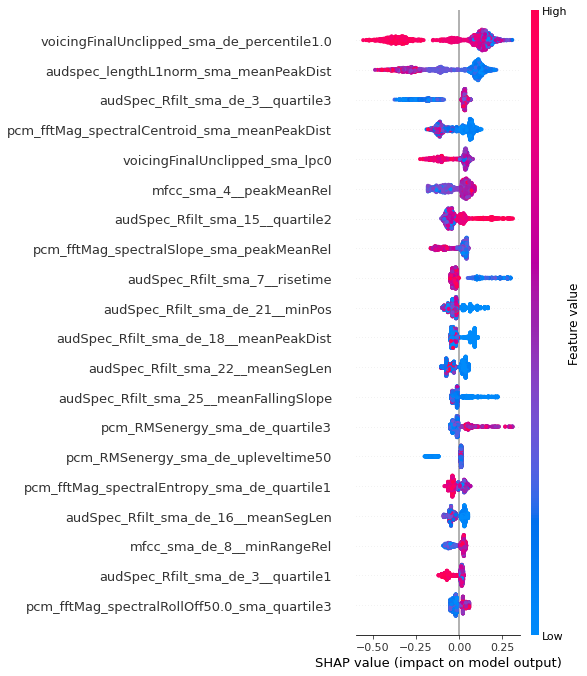

In [205]:
shap.summary_plot(shap_values[:, :, 3], feature_names=X_train_undersample.columns)

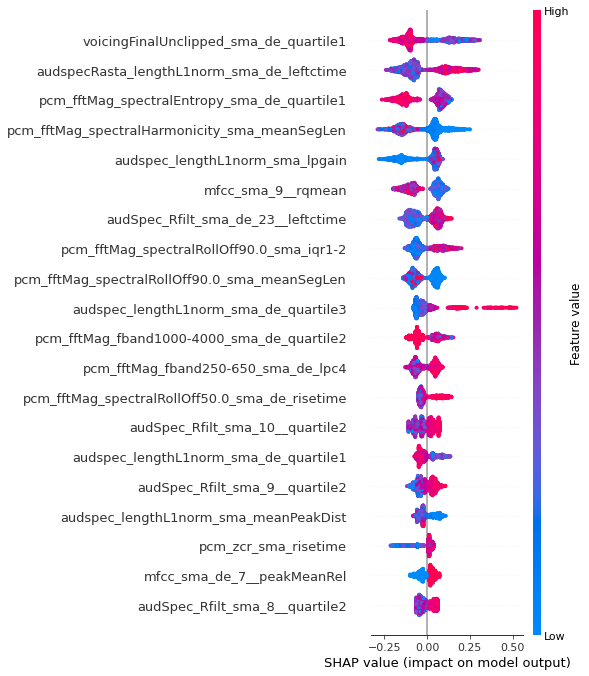

In [206]:
shap.summary_plot(shap_values[:, :, 4], feature_names=X_train_undersample.columns)

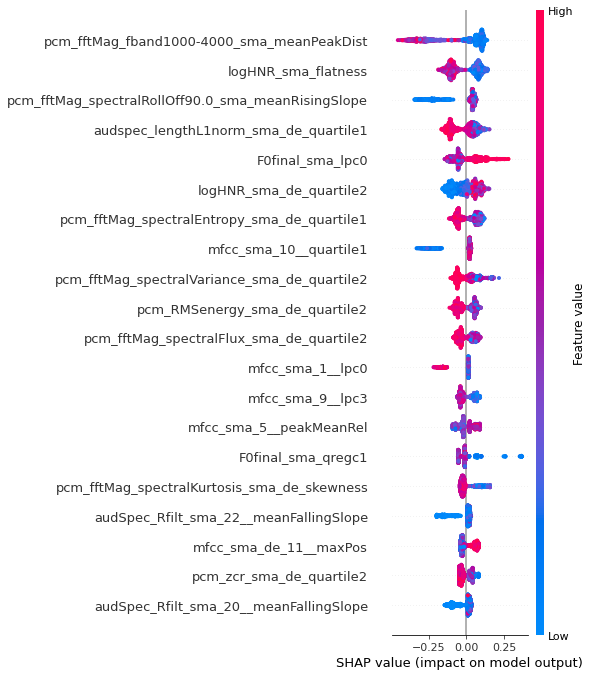

In [207]:
shap.summary_plot(shap_values[:, :, 5], feature_names=X_train_undersample.columns)

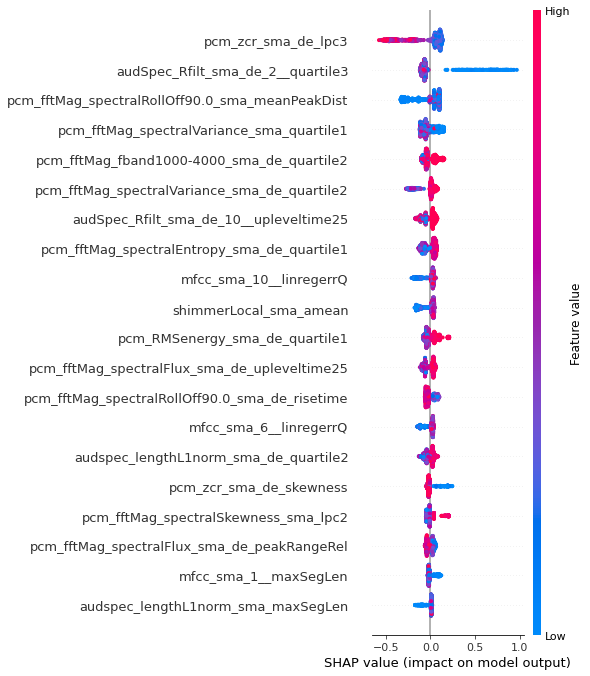

In [208]:
shap.summary_plot(shap_values[:, :, 6], feature_names=X_train_undersample.columns)

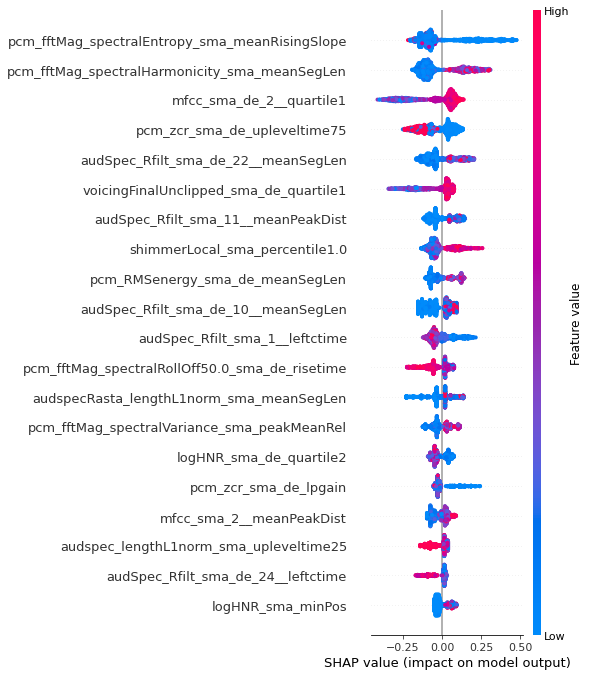

In [209]:
shap.summary_plot(shap_values[:, :, 7], feature_names=X_train_undersample.columns)

In [254]:
model = xgb.XGBClassifier(importance_type='weight')
model.set_params(**study.best_params)
model.fit(X_train_undersample, y_train_undersample)
y_true = y_test
y_pred = model.predict(X_test)

In [257]:
print('precision_macro:', precision_score(y_true, y_pred, average='macro'),
                       ' accuracy:', accuracy_score(y_true, y_pred),
                       ' recall_macro:', recall_score(y_true, y_pred, average='macro'),
                       ' f1_macro:', f1_score(y_true, y_pred, average='macro'))

precision_macro: 0.46697969939643497  accuracy: 0.4713493530499076  recall_macro: 0.47480551445225355  f1_macro: 0.4616211032948776


In [270]:
from sklearn.feature_selection import SelectFromModel
threshold = np.unique(np.sort(model.feature_importances_))
for thresh in tqdm.tqdm(threshold):
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_undersample)
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.set_params(**study.best_params)
    selection_model.fit(select_X_train, y_train_undersample)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    metric = recall_score(y_test, predictions, average='macro')
    print("Thresh=%f, n=%d, recall_score: %f" % (thresh, select_X_train.shape[1], metric))

  4%|███▏                                                                               | 1/26 [00:54<22:36, 54.25s/it]

Thresh=0.000000, n=2660, recall_score: 0.474806


  8%|██████▍                                                                            | 2/26 [01:19<14:51, 37.14s/it]

Thresh=0.000302, n=1155, recall_score: 0.474806


 12%|█████████▌                                                                         | 3/26 [01:33<10:13, 26.69s/it]

Thresh=0.000605, n=658, recall_score: 0.476444


 15%|████████████▊                                                                      | 4/26 [01:42<07:14, 19.74s/it]

Thresh=0.000907, n=397, recall_score: 0.467691


 19%|███████████████▉                                                                   | 5/26 [01:48<05:06, 14.59s/it]

Thresh=0.001209, n=272, recall_score: 0.438594


 23%|███████████████████▏                                                               | 6/26 [01:52<03:39, 10.98s/it]

Thresh=0.001511, n=190, recall_score: 0.466251


 27%|██████████████████████▎                                                            | 7/26 [01:54<02:35,  8.18s/it]

Thresh=0.001814, n=143, recall_score: 0.435415


 31%|█████████████████████████▌                                                         | 8/26 [01:56<01:50,  6.14s/it]

Thresh=0.002116, n=104, recall_score: 0.407649


 35%|████████████████████████████▋                                                      | 9/26 [01:57<01:19,  4.69s/it]

Thresh=0.002418, n=78, recall_score: 0.378208


 38%|███████████████████████████████▌                                                  | 10/26 [01:59<00:59,  3.69s/it]

Thresh=0.002721, n=57, recall_score: 0.369118


 42%|██████████████████████████████████▋                                               | 11/26 [02:00<00:43,  2.88s/it]

Thresh=0.003023, n=42, recall_score: 0.380058


 46%|█████████████████████████████████████▊                                            | 12/26 [02:01<00:32,  2.30s/it]

Thresh=0.003325, n=37, recall_score: 0.381535


 50%|█████████████████████████████████████████                                         | 13/26 [02:02<00:24,  1.87s/it]

Thresh=0.003628, n=32, recall_score: 0.361252


 54%|████████████████████████████████████████████▏                                     | 14/26 [02:03<00:18,  1.55s/it]

Thresh=0.003930, n=27, recall_score: 0.356056


 58%|███████████████████████████████████████████████▎                                  | 15/26 [02:03<00:14,  1.30s/it]

Thresh=0.004232, n=22, recall_score: 0.353580


 62%|██████████████████████████████████████████████████▍                               | 16/26 [02:04<00:11,  1.11s/it]

Thresh=0.004534, n=17, recall_score: 0.337402


 65%|█████████████████████████████████████████████████████▌                            | 17/26 [02:05<00:08,  1.04it/s]

Thresh=0.004837, n=14, recall_score: 0.349037


 69%|████████████████████████████████████████████████████████▊                         | 18/26 [02:05<00:06,  1.17it/s]

Thresh=0.005139, n=11, recall_score: 0.314206


 73%|███████████████████████████████████████████████████████████▉                      | 19/26 [02:06<00:05,  1.30it/s]

Thresh=0.005441, n=8, recall_score: 0.285362


 77%|███████████████████████████████████████████████████████████████                   | 20/26 [02:06<00:04,  1.41it/s]

Thresh=0.005744, n=7, recall_score: 0.294867


 81%|██████████████████████████████████████████████████████████████████▏               | 21/26 [02:07<00:03,  1.45it/s]

Thresh=0.006046, n=6, recall_score: 0.267850


 85%|█████████████████████████████████████████████████████████████████████▍            | 22/26 [02:08<00:02,  1.50it/s]

Thresh=0.006651, n=5, recall_score: 0.244290


 88%|████████████████████████████████████████████████████████████████████████▌         | 23/26 [02:08<00:01,  1.62it/s]

Thresh=0.006953, n=4, recall_score: 0.250420


 92%|███████████████████████████████████████████████████████████████████████████▋      | 24/26 [02:09<00:01,  1.70it/s]

Thresh=0.007557, n=3, recall_score: 0.247510


 96%|██████████████████████████████████████████████████████████████████████████████▊   | 25/26 [02:09<00:00,  1.79it/s]

Thresh=0.008767, n=2, recall_score: 0.257337


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [02:10<00:00,  5.01s/it]

Thresh=0.009674, n=1, recall_score: 0.230356


In [269]:
np.unique(np.sort(model.feature_importances_))

array([0.        , 0.0003023 , 0.00060459, 0.00090689, 0.00120919,
       0.00151149, 0.00181378, 0.00211608, 0.00241838, 0.00272068,
       0.00302297, 0.00332527, 0.00362757, 0.00392987, 0.00423216,
       0.00453446, 0.00483676, 0.00513906, 0.00544135, 0.00574365,
       0.00604595, 0.00665054, 0.00695284, 0.00755744, 0.00876663,
       0.00967352], dtype=float32)

In [284]:
feature_mask = SelectFromModel(model, threshold=0.000604, prefit=True).get_support()

In [285]:
len([i for i, x in enumerate(feature_mask) if x])

658

In [ ]:
#важность для модели без коррелированных признаков более 0.7

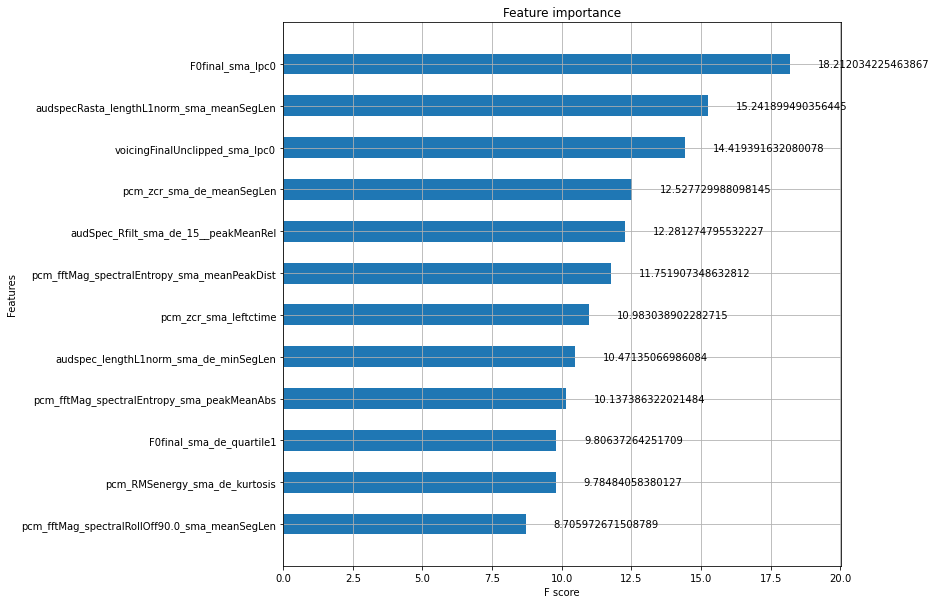

In [326]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, max_num_features=12, height=0.5, ax=ax,importance_type='gain')
plt.show()

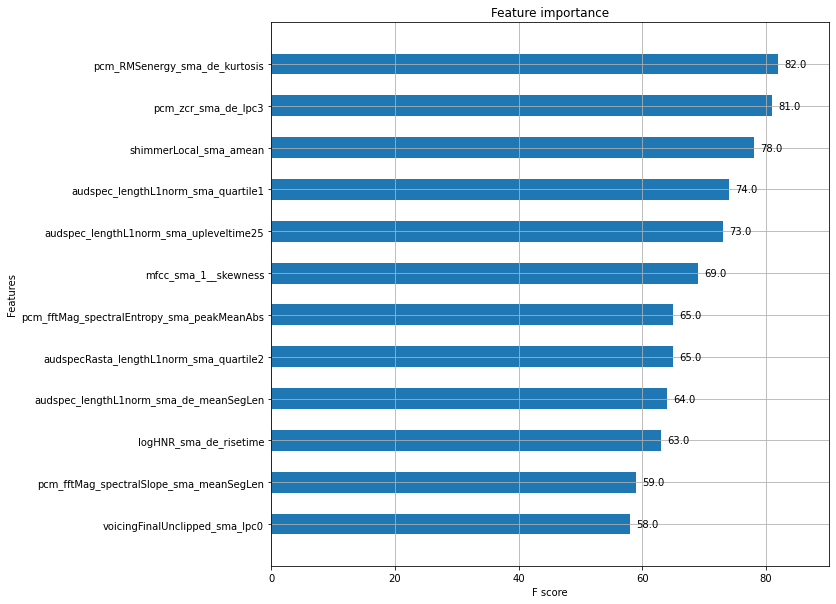

In [327]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, max_num_features=12, height=0.5, ax=ax,importance_type='weight')
plt.show()

In [321]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train_undersample)

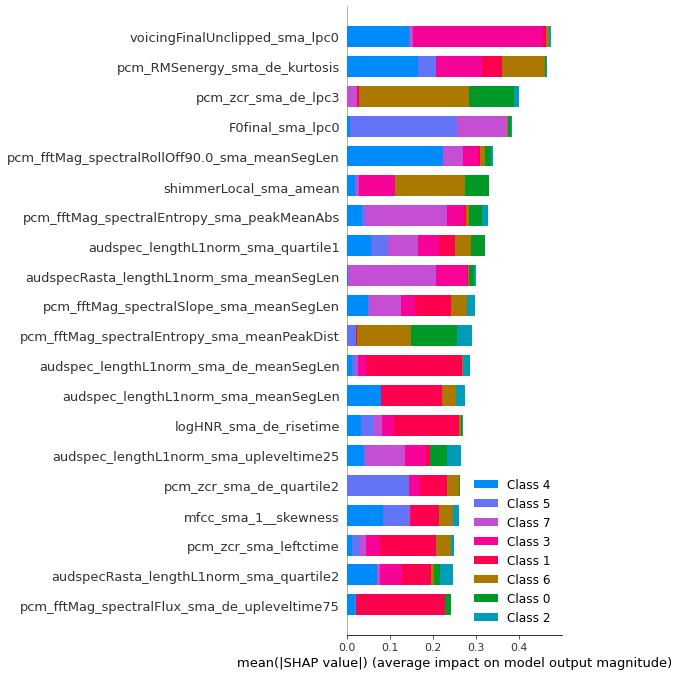

In [322]:
shap.summary_plot(
    [shap_values[:, :, class_ind].values for class_ind in range(shap_values.shape[-1])],
    feature_names=X_train_undersample.columns,
    plot_type="bar")

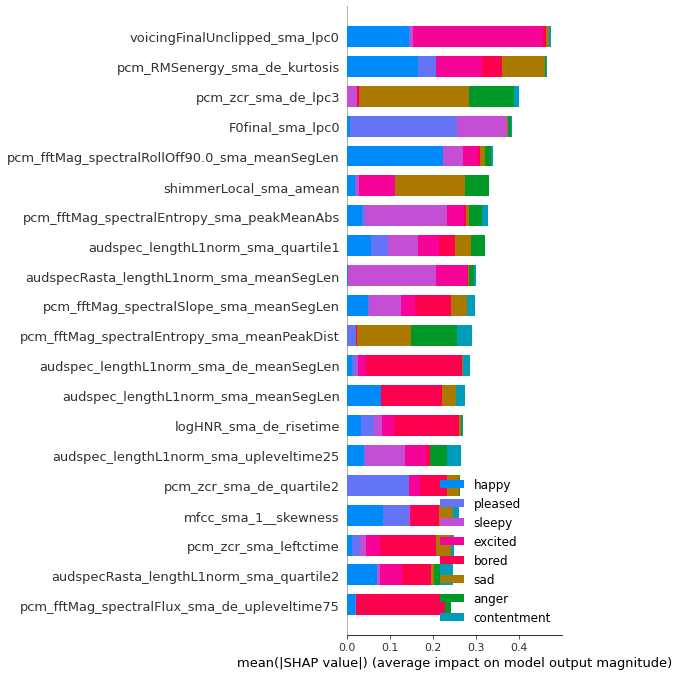

In [324]:
shap.summary_plot(
    [shap_values[:, :, class_ind].values for class_ind in range(shap_values.shape[-1])],
    feature_names=X_train_undersample.columns,
    plot_type="bar",
    class_names=label_encoder.inverse_transform(model.classes_)
)

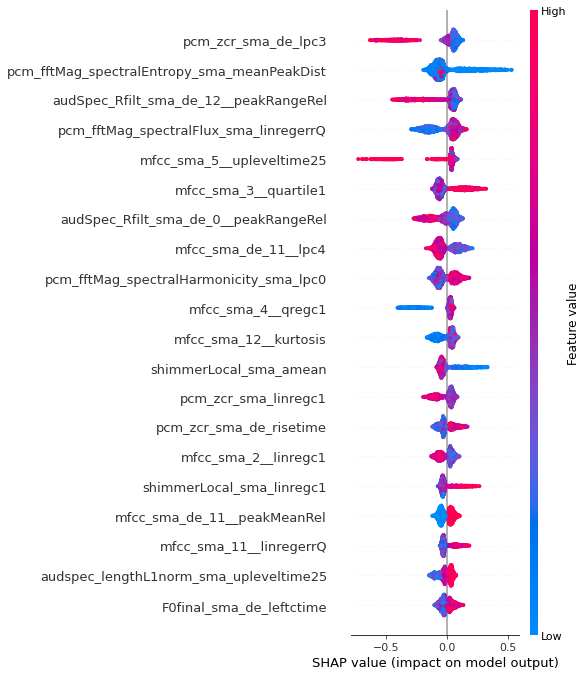

In [325]:
shap.summary_plot(shap_values[:, :, 0], feature_names=X_train_undersample.columns)

In [331]:
#gain
threshold = np.unique(np.sort(model.feature_importances_))[0:len(np.unique(np.sort(model.feature_importances_))):10]
for thresh in tqdm.tqdm(threshold):
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_undersample)
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.set_params(**study.best_params)
    selection_model.fit(select_X_train, y_train_undersample)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    metric = recall_score(y_test, predictions, average='macro')
    print("Thresh=%f, n=%d, recall_score: %f" % (thresh, select_X_train.shape[1], metric))


  1%|▉                                                                                | 1/90 [01:19<1:57:34, 79.27s/it]

Thresh=0.000000, n=920, recall_score: 0.593890



  2%|█▊                                                                               | 2/90 [02:39<1:57:20, 80.00s/it]

Thresh=0.000391, n=881, recall_score: 0.588956



  3%|██▋                                                                              | 3/90 [03:57<1:54:27, 78.94s/it]

Thresh=0.000448, n=871, recall_score: 0.582081



  4%|███▌                                                                             | 4/90 [05:15<1:52:54, 78.77s/it]

Thresh=0.000508, n=861, recall_score: 0.584272



  6%|████▌                                                                            | 5/90 [06:34<1:51:23, 78.64s/it]

Thresh=0.000534, n=851, recall_score: 0.589898



  7%|█████▍                                                                           | 6/90 [08:25<2:05:23, 89.57s/it]

Thresh=0.000556, n=841, recall_score: 0.600926



  8%|██████▎                                                                          | 7/90 [09:50<2:02:07, 88.29s/it]

Thresh=0.000575, n=831, recall_score: 0.587550



  9%|███████                                                                         | 8/90 [12:19<2:27:03, 107.61s/it]

Thresh=0.000595, n=821, recall_score: 0.588814



 10%|████████                                                                         | 9/90 [13:39<2:13:23, 98.81s/it]

Thresh=0.000618, n=811, recall_score: 0.581776



 11%|████████▉                                                                       | 10/90 [15:00<2:04:29, 93.37s/it]

Thresh=0.000631, n=801, recall_score: 0.581430



 12%|█████████▊                                                                      | 11/90 [16:12<1:54:32, 87.00s/it]

Thresh=0.000645, n=791, recall_score: 0.577902



 13%|██████████▌                                                                    | 12/90 [18:29<2:12:34, 101.98s/it]

Thresh=0.000667, n=781, recall_score: 0.579293



 14%|███████████▌                                                                    | 13/90 [19:44<2:00:38, 94.01s/it]

Thresh=0.000679, n=771, recall_score: 0.586396



 16%|████████████▍                                                                   | 14/90 [20:56<1:50:21, 87.12s/it]

Thresh=0.000687, n=761, recall_score: 0.575581



 17%|█████████████▎                                                                  | 15/90 [22:04<1:41:50, 81.48s/it]

Thresh=0.000697, n=751, recall_score: 0.579626



 18%|██████████████▏                                                                 | 16/90 [23:14<1:36:04, 77.90s/it]

Thresh=0.000709, n=741, recall_score: 0.583214



 19%|███████████████                                                                 | 17/90 [24:23<1:31:46, 75.43s/it]

Thresh=0.000723, n=731, recall_score: 0.592373



 20%|████████████████                                                                | 18/90 [25:31<1:27:44, 73.12s/it]

Thresh=0.000733, n=721, recall_score: 0.587265



 21%|████████████████▉                                                               | 19/90 [26:39<1:24:36, 71.50s/it]

Thresh=0.000743, n=711, recall_score: 0.577129



 22%|█████████████████▊                                                              | 20/90 [27:51<1:23:37, 71.68s/it]

Thresh=0.000751, n=701, recall_score: 0.582856



 23%|██████████████████▋                                                             | 21/90 [29:07<1:24:01, 73.07s/it]

Thresh=0.000756, n=691, recall_score: 0.583624



 24%|███████████████████▌                                                            | 22/90 [30:23<1:23:45, 73.91s/it]

Thresh=0.000768, n=681, recall_score: 0.592035



 26%|████████████████████▍                                                           | 23/90 [31:35<1:21:55, 73.36s/it]

Thresh=0.000780, n=671, recall_score: 0.579936



 27%|█████████████████████▎                                                          | 24/90 [32:44<1:19:20, 72.13s/it]

Thresh=0.000791, n=661, recall_score: 0.573670



 28%|██████████████████████▏                                                         | 25/90 [33:48<1:15:23, 69.60s/it]

Thresh=0.000805, n=651, recall_score: 0.590921



 29%|███████████████████████                                                         | 26/90 [34:51<1:11:58, 67.48s/it]

Thresh=0.000813, n=641, recall_score: 0.572852



 30%|████████████████████████                                                        | 27/90 [35:49<1:07:52, 64.64s/it]

Thresh=0.000824, n=631, recall_score: 0.589066



 31%|████████████████████████▉                                                       | 28/90 [36:52<1:06:15, 64.11s/it]

Thresh=0.000835, n=621, recall_score: 0.594963



 32%|█████████████████████████▊                                                      | 29/90 [37:47<1:02:38, 61.62s/it]

Thresh=0.000844, n=611, recall_score: 0.578927



 33%|███████████████████████████▎                                                      | 30/90 [38:43<59:47, 59.79s/it]

Thresh=0.000853, n=601, recall_score: 0.554284



 34%|████████████████████████████▏                                                     | 31/90 [39:40<57:56, 58.92s/it]

Thresh=0.000870, n=591, recall_score: 0.584402



 36%|█████████████████████████████▏                                                    | 32/90 [40:38<56:41, 58.65s/it]

Thresh=0.000881, n=581, recall_score: 0.574026



 37%|██████████████████████████████                                                    | 33/90 [41:39<56:26, 59.42s/it]

Thresh=0.000893, n=571, recall_score: 0.585095



 38%|██████████████████████████████▉                                                   | 34/90 [42:34<54:21, 58.24s/it]

Thresh=0.000904, n=561, recall_score: 0.584748



 39%|███████████████████████████████▉                                                  | 35/90 [43:30<52:31, 57.30s/it]

Thresh=0.000919, n=551, recall_score: 0.580031



 40%|████████████████████████████████▊                                                 | 36/90 [44:21<50:02, 55.60s/it]

Thresh=0.000931, n=541, recall_score: 0.558580



 41%|█████████████████████████████████▋                                                | 37/90 [45:09<46:56, 53.15s/it]

Thresh=0.000942, n=531, recall_score: 0.573632



 42%|██████████████████████████████████▌                                               | 38/90 [46:00<45:38, 52.66s/it]

Thresh=0.000956, n=521, recall_score: 0.572287


Thresh=0.000959, n=511, recall_score: 0.560984


 44%|████████████████████████████████████▍                                             | 40/90 [47:39<42:42, 51.25s/it]

Thresh=0.000964, n=501, recall_score: 0.572489



 46%|█████████████████████████████████████▎                                            | 41/90 [48:28<41:19, 50.60s/it]

Thresh=0.000973, n=491, recall_score: 0.564952



 47%|██████████████████████████████████████▎                                           | 42/90 [49:17<40:02, 50.04s/it]

Thresh=0.000979, n=481, recall_score: 0.578690



 48%|███████████████████████████████████████▏                                          | 43/90 [50:00<37:36, 48.01s/it]

Thresh=0.000990, n=471, recall_score: 0.554179



 49%|████████████████████████████████████████                                          | 44/90 [50:42<35:22, 46.14s/it]

Thresh=0.000998, n=461, recall_score: 0.560068



 50%|█████████████████████████████████████████                                         | 45/90 [51:24<33:37, 44.83s/it]

Thresh=0.001015, n=451, recall_score: 0.571436



 51%|█████████████████████████████████████████▉                                        | 46/90 [52:07<32:26, 44.23s/it]

Thresh=0.001025, n=441, recall_score: 0.564494



 52%|██████████████████████████████████████████▊                                       | 47/90 [52:53<32:11, 44.93s/it]

Thresh=0.001033, n=431, recall_score: 0.576862



 53%|███████████████████████████████████████████▋                                      | 48/90 [53:35<30:48, 44.00s/it]

Thresh=0.001046, n=421, recall_score: 0.589094



 54%|████████████████████████████████████████████▋                                     | 49/90 [54:16<29:18, 42.90s/it]

Thresh=0.001057, n=411, recall_score: 0.575267



 56%|█████████████████████████████████████████████▌                                    | 50/90 [54:54<27:37, 41.44s/it]

Thresh=0.001077, n=401, recall_score: 0.569897



 57%|██████████████████████████████████████████████▍                                   | 51/90 [55:30<25:56, 39.90s/it]

Thresh=0.001085, n=391, recall_score: 0.565304



 58%|███████████████████████████████████████████████▍                                  | 52/90 [56:05<24:25, 38.57s/it]

Thresh=0.001093, n=381, recall_score: 0.573968



 59%|████████████████████████████████████████████████▎                                 | 53/90 [56:40<22:58, 37.25s/it]

Thresh=0.001098, n=371, recall_score: 0.584023



 60%|█████████████████████████████████████████████████▏                                | 54/90 [57:16<22:10, 36.95s/it]

Thresh=0.001111, n=361, recall_score: 0.574671



 61%|██████████████████████████████████████████████████                                | 55/90 [57:50<21:09, 36.26s/it]

Thresh=0.001124, n=351, recall_score: 0.580065



 62%|███████████████████████████████████████████████████                               | 56/90 [58:22<19:44, 34.82s/it]

Thresh=0.001132, n=341, recall_score: 0.567559



 63%|███████████████████████████████████████████████████▉                              | 57/90 [58:54<18:43, 34.05s/it]

Thresh=0.001150, n=331, recall_score: 0.566796



 64%|████████████████████████████████████████████████████▊                             | 58/90 [59:25<17:37, 33.05s/it]

Thresh=0.001163, n=321, recall_score: 0.547400



 66%|█████████████████████████████████████████████████████▊                            | 59/90 [59:53<16:21, 31.68s/it]

Thresh=0.001176, n=311, recall_score: 0.562329



 67%|█████████████████████████████████████████████████████▎                          | 60/90 [1:00:23<15:29, 30.97s/it]

Thresh=0.001186, n=301, recall_score: 0.549565



 68%|██████████████████████████████████████████████████████▏                         | 61/90 [1:00:52<14:40, 30.35s/it]

Thresh=0.001200, n=291, recall_score: 0.540789



 69%|███████████████████████████████████████████████████████                         | 62/90 [1:01:21<13:58, 29.95s/it]

Thresh=0.001215, n=281, recall_score: 0.561287



 70%|████████████████████████████████████████████████████████                        | 63/90 [1:01:54<13:59, 31.08s/it]

Thresh=0.001232, n=271, recall_score: 0.550205


 70%|████████████████████████████████████████████████████████                        | 63/90 [1:02:18<26:42, 59.34s/it]


KeyboardInterrupt: 

In [332]:
#weight
model = xgb.XGBClassifier(importance_type='weight')
model.set_params(**study.best_params)
model.fit(X_train_undersample, y_train_undersample)
y_true = y_test
y_pred = model.predict(X_test)
threshold = np.unique(np.sort(model.feature_importances_))
for thresh in tqdm.tqdm(threshold):
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_undersample)
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.set_params(**study.best_params)
    selection_model.fit(select_X_train, y_train_undersample)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    metric = recall_score(y_test, predictions, average='macro')
    print("Thresh=%f, n=%d, recall_score: %f" % (thresh, select_X_train.shape[1], metric))


  2%|█▏                                                                               | 1/65 [01:22<1:28:14, 82.72s/it]

Thresh=0.000000, n=920, recall_score: 0.593890



  3%|██▍                                                                              | 2/65 [02:49<1:29:26, 85.18s/it]

Thresh=0.000075, n=890, recall_score: 0.593890



  5%|███▋                                                                             | 3/65 [04:11<1:26:17, 83.51s/it]

Thresh=0.000150, n=865, recall_score: 0.578238



  6%|████▉                                                                            | 4/65 [05:28<1:22:37, 81.27s/it]

Thresh=0.000225, n=837, recall_score: 0.603481



  8%|██████▏                                                                          | 5/65 [06:44<1:19:01, 79.02s/it]

Thresh=0.000299, n=813, recall_score: 0.598049



  9%|███████▍                                                                         | 6/65 [07:56<1:15:24, 76.68s/it]

Thresh=0.000374, n=764, recall_score: 0.593722



 11%|████████▋                                                                        | 7/65 [09:07<1:12:33, 75.06s/it]

Thresh=0.000449, n=724, recall_score: 0.597548



 12%|█████████▉                                                                       | 8/65 [10:13<1:08:29, 72.10s/it]

Thresh=0.000524, n=676, recall_score: 0.601890



 14%|███████████▏                                                                     | 9/65 [11:11<1:03:06, 67.62s/it]

Thresh=0.000599, n=624, recall_score: 0.588291



 15%|████████████▌                                                                     | 10/65 [12:07<58:39, 63.99s/it]

Thresh=0.000674, n=582, recall_score: 0.582687



 17%|█████████████▉                                                                    | 11/65 [12:55<53:13, 59.14s/it]

Thresh=0.000749, n=529, recall_score: 0.588611



 18%|███████████████▏                                                                  | 12/65 [13:37<47:39, 53.95s/it]

Thresh=0.000824, n=496, recall_score: 0.583163



 20%|████████████████▍                                                                 | 13/65 [14:18<43:28, 50.16s/it]

Thresh=0.000898, n=455, recall_score: 0.592394



 22%|█████████████████▋                                                                | 14/65 [14:56<39:28, 46.45s/it]

Thresh=0.000973, n=419, recall_score: 0.583500



 23%|██████████████████▉                                                               | 15/65 [15:32<36:05, 43.31s/it]

Thresh=0.001048, n=379, recall_score: 0.570543



 25%|████████████████████▏                                                             | 16/65 [16:05<32:39, 39.99s/it]

Thresh=0.001123, n=346, recall_score: 0.585343



 26%|█████████████████████▍                                                            | 17/65 [16:33<29:11, 36.49s/it]

Thresh=0.001198, n=309, recall_score: 0.601762



 28%|██████████████████████▋                                                           | 18/65 [16:58<25:53, 33.05s/it]

Thresh=0.001273, n=278, recall_score: 0.582689



 29%|███████████████████████▉                                                          | 19/65 [17:22<23:19, 30.41s/it]

Thresh=0.001348, n=259, recall_score: 0.592425



 31%|█████████████████████████▏                                                        | 20/65 [17:47<21:27, 28.61s/it]

Thresh=0.001422, n=241, recall_score: 0.571454



 32%|██████████████████████████▍                                                       | 21/65 [18:07<19:14, 26.23s/it]

Thresh=0.001497, n=223, recall_score: 0.544820



 34%|███████████████████████████▊                                                      | 22/65 [18:26<17:03, 23.81s/it]

Thresh=0.001572, n=201, recall_score: 0.554457



 35%|█████████████████████████████                                                     | 23/65 [18:43<15:23, 21.99s/it]

Thresh=0.001647, n=185, recall_score: 0.553914



 37%|██████████████████████████████▎                                                   | 24/65 [18:58<13:35, 19.89s/it]

Thresh=0.001722, n=171, recall_score: 0.543316



 38%|███████████████████████████████▌                                                  | 25/65 [19:13<12:10, 18.27s/it]

Thresh=0.001797, n=157, recall_score: 0.559821



 40%|████████████████████████████████▊                                                 | 26/65 [19:25<10:44, 16.52s/it]

Thresh=0.001872, n=143, recall_score: 0.536471



 42%|██████████████████████████████████                                                | 27/65 [19:37<09:30, 15.02s/it]

Thresh=0.001947, n=125, recall_score: 0.528737



 43%|███████████████████████████████████▎                                              | 28/65 [19:48<08:29, 13.78s/it]

Thresh=0.002021, n=116, recall_score: 0.526080



 45%|████████████████████████████████████▌                                             | 29/65 [19:58<07:40, 12.80s/it]

Thresh=0.002096, n=109, recall_score: 0.515582



 46%|█████████████████████████████████████▊                                            | 30/65 [20:08<06:58, 11.95s/it]

Thresh=0.002171, n=99, recall_score: 0.510810



 48%|███████████████████████████████████████                                           | 31/65 [20:17<06:13, 10.99s/it]

Thresh=0.002246, n=93, recall_score: 0.524455



 49%|████████████████████████████████████████▎                                         | 32/65 [20:24<05:23,  9.81s/it]

Thresh=0.002321, n=84, recall_score: 0.498173



 51%|█████████████████████████████████████████▋                                        | 33/65 [20:31<04:50,  9.08s/it]

Thresh=0.002396, n=80, recall_score: 0.501731



 52%|██████████████████████████████████████████▉                                       | 34/65 [20:38<04:19,  8.38s/it]

Thresh=0.002471, n=78, recall_score: 0.508264



 54%|████████████████████████████████████████████▏                                     | 35/65 [20:45<03:59,  7.98s/it]

Thresh=0.002545, n=69, recall_score: 0.479334



 55%|█████████████████████████████████████████████▍                                    | 36/65 [20:51<03:32,  7.34s/it]

Thresh=0.002620, n=62, recall_score: 0.493664



 57%|██████████████████████████████████████████████▋                                   | 37/65 [20:56<03:08,  6.74s/it]

Thresh=0.002695, n=60, recall_score: 0.456766



 58%|███████████████████████████████████████████████▉                                  | 38/65 [21:02<02:50,  6.32s/it]

Thresh=0.002770, n=58, recall_score: 0.469813



 60%|█████████████████████████████████████████████████▏                                | 39/65 [21:07<02:33,  5.91s/it]

Thresh=0.002845, n=53, recall_score: 0.445403



 62%|██████████████████████████████████████████████████▍                               | 40/65 [21:12<02:21,  5.66s/it]

Thresh=0.002920, n=50, recall_score: 0.434493



 63%|███████████████████████████████████████████████████▋                              | 41/65 [21:16<02:05,  5.23s/it]

Thresh=0.002995, n=48, recall_score: 0.460882



 65%|████████████████████████████████████████████████████▉                             | 42/65 [21:20<01:51,  4.87s/it]

Thresh=0.003070, n=44, recall_score: 0.440930



 66%|██████████████████████████████████████████████████████▏                           | 43/65 [21:24<01:45,  4.78s/it]

Thresh=0.003144, n=40, recall_score: 0.456394



 68%|███████████████████████████████████████████████████████▌                          | 44/65 [21:30<01:42,  4.90s/it]

Thresh=0.003219, n=37, recall_score: 0.442145



 69%|████████████████████████████████████████████████████████▊                         | 45/65 [21:33<01:28,  4.44s/it]

Thresh=0.003519, n=32, recall_score: 0.417988



 71%|██████████████████████████████████████████████████████████                        | 46/65 [21:36<01:15,  3.98s/it]

Thresh=0.003594, n=30, recall_score: 0.413622



 72%|███████████████████████████████████████████████████████████▎                      | 47/65 [21:39<01:05,  3.65s/it]

Thresh=0.003668, n=26, recall_score: 0.406960



 74%|████████████████████████████████████████████████████████████▌                     | 48/65 [21:42<00:57,  3.40s/it]

Thresh=0.003743, n=25, recall_score: 0.399105



 75%|█████████████████████████████████████████████████████████████▊                    | 49/65 [21:44<00:49,  3.12s/it]

Thresh=0.003818, n=23, recall_score: 0.386017



 77%|███████████████████████████████████████████████████████████████                   | 50/65 [21:46<00:43,  2.88s/it]

Thresh=0.003968, n=20, recall_score: 0.356685



 78%|████████████████████████████████████████████████████████████████▎                 | 51/65 [21:49<00:38,  2.75s/it]

Thresh=0.004043, n=18, recall_score: 0.382330



 80%|█████████████████████████████████████████████████████████████████▌                | 52/65 [21:51<00:34,  2.65s/it]

Thresh=0.004118, n=17, recall_score: 0.359614



 82%|██████████████████████████████████████████████████████████████████▊               | 53/65 [21:53<00:29,  2.48s/it]

Thresh=0.004193, n=16, recall_score: 0.343469



 83%|████████████████████████████████████████████████████████████████████              | 54/65 [21:56<00:26,  2.40s/it]

Thresh=0.004267, n=15, recall_score: 0.343106



 85%|█████████████████████████████████████████████████████████████████████▍            | 55/65 [21:58<00:23,  2.37s/it]

Thresh=0.004342, n=13, recall_score: 0.324428



 86%|██████████████████████████████████████████████████████████████████████▋           | 56/65 [22:00<00:20,  2.32s/it]

Thresh=0.004417, n=11, recall_score: 0.314694



 88%|███████████████████████████████████████████████████████████████████████▉          | 57/65 [22:02<00:17,  2.20s/it]

Thresh=0.004717, n=10, recall_score: 0.324571



 89%|█████████████████████████████████████████████████████████████████████████▏        | 58/65 [22:04<00:15,  2.16s/it]

Thresh=0.004791, n=9, recall_score: 0.308156



 91%|██████████████████████████████████████████████████████████████████████████▍       | 59/65 [22:07<00:13,  2.33s/it]

Thresh=0.004866, n=8, recall_score: 0.304546



 92%|███████████████████████████████████████████████████████████████████████████▋      | 60/65 [22:09<00:11,  2.31s/it]

Thresh=0.005166, n=6, recall_score: 0.304068



 94%|████████████████████████████████████████████████████████████████████████████▉     | 61/65 [22:12<00:10,  2.52s/it]

Thresh=0.005465, n=5, recall_score: 0.244909



 95%|██████████████████████████████████████████████████████████████████████████████▏   | 62/65 [22:13<00:06,  2.18s/it]

Thresh=0.005540, n=4, recall_score: 0.242748



 97%|███████████████████████████████████████████████████████████████████████████████▍  | 63/65 [22:16<00:04,  2.26s/it]

Thresh=0.005840, n=3, recall_score: 0.224723



 98%|████████████████████████████████████████████████████████████████████████████████▋ | 64/65 [22:18<00:02,  2.12s/it]

Thresh=0.006064, n=2, recall_score: 0.236879



100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [22:19<00:00,  1.86s/it]

Thresh=0.006139, n=1, recall_score: 0.210174


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [22:19<00:00, 20.61s/it]


In [335]:
#weight
model = xgb.XGBClassifier(importance_type='weight')
model.set_params(**study.best_params)
model.fit(X_train_undersample, y_train_undersample)
y_true = y_test
y_pred = model.predict(X_test)

In [336]:
selection = SelectFromModel(model, threshold=0.000224, prefit=True)
select_X_train = selection.transform(X_train_undersample)
selection_model = xgb.XGBClassifier()
selection_model.set_params(**study.best_params)
selection_model.fit(select_X_train, y_train_undersample)

XGBClassifier(alpha=0.2, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.6000000000000001,
              learning_rate=0.060000000000000005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=19, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=190, n_jobs=None, ...)

In [340]:
y_true = y_test
y_pred = selection_model.predict(selection.transform(X_test))
print('precision_macro:', precision_score(y_true, y_pred, average='macro'),
                       ' accuracy:', accuracy_score(y_true, y_pred),
                       ' recall_macro:', recall_score(y_true, y_pred, average='macro'),
                       ' f1_macro:', f1_score(y_true, y_pred, average='macro'))

precision_macro: 0.5940829794112187  accuracy: 0.5951940850277264  recall_macro: 0.6034805130729044  f1_macro: 0.5935486669826253


In [ ]:
#сохранение модели, scaler и выбранных признаков для телеграм бота

In [341]:
dump(selection_model, '../Downloads/model_59acc.joblib')

['../Downloads/model_59acc.joblib']

In [342]:
dump(scaler, '../Downloads/scaler.joblib')

['../Downloads/scaler.joblib']

In [345]:
with open("feature_cols", "wb") as fp:   #Pickling
    pickle.dump(list(selection.get_support(indices=True)), fp)